In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [4]:
image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> V1 !!!!! K-Fold Training and Evaluation</h2>

In [8]:
folder = "models"
mode_version = "mel_smote_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v1


In [9]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 72)        100872

In [11]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 5s - loss: 1.4669 - accuracy: 0.4506 - val_loss: 1.1178 - val_accuracy: 0.5515
Epoch 2/100
1199/1199 - 6s - loss: 0.7928 - accuracy: 0.7135 - val_loss: 0.7802 - val_accuracy: 0.7261
Epoch 3/100
1199/1199 - 5s - loss: 0.4250 - accuracy: 0.8599 - val_loss: 0.4456 - val_accuracy: 0.8346
Epoch 4/100
1199/1199 - 7s - loss: 0.3107 - accuracy: 0.8990 - val_loss: 0.3039 - val_accuracy: 0.8989
Epoch 5/100
1199/1199 - 5s - loss: 0.2538 - accuracy: 0.9196 - val_loss: 0.2075 - val_accuracy: 0.9228

Epoch 18/100
1199/1199 - 5s - loss: 0.0852 - accuracy: 0.9736 - val_loss: 0.1961 - val_accuracy: 0.9577
Epoch 19/100
1199/1199 - 5s - loss: 0.0739 - accuracy: 0.9781 - val_loss: 0.1197 - val_accuracy: 0.9688
Epoch 20/100
1199/1199 - 5s - loss: 0.0879 - accuracy: 0.9719 - val_loss: 0.1032 - val_accuracy: 0.9724
Epoch 21/100
1199/1199 - 6s - loss: 0.0767 - accuracy: 0.9770 - val_loss: 0.1079 - val_accuracy: 0.9779
Epoch 22/100
1199/1199 - 5s - loss: 0.0715 - accuracy: 0.9786 - val_loss: 0.0958 - val_accuracy: 0.9761
Epoch 23/100
1199/1199 - 5s - loss: 0.0755 - accuracy: 0.9775 - val_loss: 0.1788 - val_accuracy: 0.9596
Epoch 24/100
1199/1199 - 5s - loss: 0.0504 - accuracy: 0.9843 - val_loss: 0.1307 - val_accuracy: 0.9724
Epoch 25/100
1199/1199 - 5s - loss: 0.0787 - accuracy: 0.9764 - val_loss: 0.0814 - val_accuracy: 0.9761
Epoch 26/100
1199/1199 - 5s - loss: 0.0594 - accuracy: 0.9814 - val_loss: 0.1121 - val_accuracy: 0.9761
Epoch 27/100
1199/1199 - 5s - loss: 0.0520 - accuracy: 0.9830 - 

Epoch 46/100
1199/1199 - 5s - loss: 0.0430 - accuracy: 0.9876 - val_loss: 0.1430 - val_accuracy: 0.9706
Epoch 47/100
1199/1199 - 5s - loss: 0.0508 - accuracy: 0.9850 - val_loss: 0.1129 - val_accuracy: 0.9669
Epoch 48/100
1199/1199 - 5s - loss: 0.0344 - accuracy: 0.9889 - val_loss: 0.1263 - val_accuracy: 0.9632
Epoch 49/100
Restoring model weights from the end of the best epoch.
1199/1199 - 5s - loss: 0.0378 - accuracy: 0.9893 - val_loss: 0.2186 - val_accuracy: 0.9577
Epoch 00049: early stopping
models/mel_smote_v1_iter_3.model
INFO:tensorflow:Assets written to: models/mel_smote_v1_iter_3.model/assets
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('R.nasutus', 193), ('M.emarginatus', 81), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.triden

Epoch 12/100
1198/1198 - 5s - loss: 0.1138 - accuracy: 0.9664 - val_loss: 0.1318 - val_accuracy: 0.9724
Epoch 13/100
1198/1198 - 5s - loss: 0.1085 - accuracy: 0.9683 - val_loss: 0.1641 - val_accuracy: 0.9467
Epoch 14/100
1198/1198 - 5s - loss: 0.0941 - accuracy: 0.9694 - val_loss: 0.1711 - val_accuracy: 0.9632
Epoch 15/100
1198/1198 - 5s - loss: 0.0962 - accuracy: 0.9678 - val_loss: 0.1428 - val_accuracy: 0.9559
Epoch 16/100
1198/1198 - 5s - loss: 0.0995 - accuracy: 0.9708 - val_loss: 0.1337 - val_accuracy: 0.9632
Epoch 17/100
1198/1198 - 5s - loss: 0.0841 - accuracy: 0.9735 - val_loss: 0.1762 - val_accuracy: 0.9559
Epoch 18/100
1198/1198 - 5s - loss: 0.0834 - accuracy: 0.9741 - val_loss: 0.1307 - val_accuracy: 0.9632
Epoch 19/100
1198/1198 - 6s - loss: 0.0766 - accuracy: 0.9773 - val_loss: 0.1233 - val_accuracy: 0.9724
Epoch 20/100
1198/1198 - 5s - loss: 0.0778 - accuracy: 0.9757 - val_loss: 0.1408 - val_accuracy: 0.9651
Epoch 21/100
1198/1198 - 5s - loss: 0.0754 - accuracy: 0.9758 - 

Epoch 11/100
1198/1198 - 5s - loss: 0.1050 - accuracy: 0.9666 - val_loss: 0.2455 - val_accuracy: 0.9228
Epoch 12/100
1198/1198 - 5s - loss: 0.1174 - accuracy: 0.9638 - val_loss: 0.2098 - val_accuracy: 0.9485
Epoch 13/100
1198/1198 - 5s - loss: 0.1088 - accuracy: 0.9670 - val_loss: 0.1888 - val_accuracy: 0.9412
Epoch 14/100
1198/1198 - 5s - loss: 0.0943 - accuracy: 0.9704 - val_loss: 0.2088 - val_accuracy: 0.9467
Epoch 15/100
1198/1198 - 5s - loss: 0.0848 - accuracy: 0.9732 - val_loss: 0.1914 - val_accuracy: 0.9540
Epoch 16/100
1198/1198 - 6s - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.2029 - val_accuracy: 0.9504
Epoch 17/100
1198/1198 - 5s - loss: 0.0813 - accuracy: 0.9746 - val_loss: 0.1903 - val_accuracy: 0.9559
Epoch 18/100
1198/1198 - 5s - loss: 0.0809 - accuracy: 0.9759 - val_loss: 0.1549 - val_accuracy: 0.9651
Epoch 19/100
1198/1198 - 5s - loss: 0.0831 - accuracy: 0.9749 - val_loss: 0.1515 - val_accuracy: 0.9614
Epoch 20/100
1198/1198 - 5s - loss: 0.0715 - accuracy: 0.9784 - 

Epoch 25/100
1198/1198 - 6s - loss: 0.0682 - accuracy: 0.9782 - val_loss: 0.1091 - val_accuracy: 0.9779
Epoch 26/100
1198/1198 - 5s - loss: 0.0643 - accuracy: 0.9809 - val_loss: 0.1995 - val_accuracy: 0.9485
Epoch 27/100
1198/1198 - 5s - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.1511 - val_accuracy: 0.9688
Epoch 28/100
1198/1198 - 5s - loss: 0.0571 - accuracy: 0.9815 - val_loss: 0.1593 - val_accuracy: 0.9724
Epoch 29/100
1198/1198 - 5s - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.1126 - val_accuracy: 0.9779
Epoch 30/100
1198/1198 - 5s - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.1245 - val_accuracy: 0.9651
Epoch 31/100
1198/1198 - 5s - loss: 0.0506 - accuracy: 0.9842 - val_loss: 0.1371 - val_accuracy: 0.9724
Epoch 32/100
1198/1198 - 5s - loss: 0.0655 - accuracy: 0.9814 - val_loss: 0.1322 - val_accuracy: 0.9798
Epoch 33/100
1198/1198 - 5s - loss: 0.0557 - accuracy: 0.9840 - val_loss: 0.1624 - val_accuracy: 0.9669
Epoch 34/100
1198/1198 - 5s - loss: 0.0561 - accuracy: 0.9838 - 

Epoch 24/100
1198/1198 - 5s - loss: 0.0879 - accuracy: 0.9732 - val_loss: 0.1220 - val_accuracy: 0.9724
Epoch 25/100
1198/1198 - 5s - loss: 0.0606 - accuracy: 0.9794 - val_loss: 0.1583 - val_accuracy: 0.9669
Epoch 26/100
1198/1198 - 5s - loss: 0.0726 - accuracy: 0.9773 - val_loss: 0.1495 - val_accuracy: 0.9577
Epoch 27/100
1198/1198 - 5s - loss: 0.0778 - accuracy: 0.9776 - val_loss: 0.1595 - val_accuracy: 0.9577
Epoch 28/100
1198/1198 - 5s - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.1679 - val_accuracy: 0.9559
Epoch 29/100
1198/1198 - 5s - loss: 0.0726 - accuracy: 0.9783 - val_loss: 0.1232 - val_accuracy: 0.9669
Epoch 30/100
1198/1198 - 5s - loss: 0.0590 - accuracy: 0.9825 - val_loss: 0.1047 - val_accuracy: 0.9761
Epoch 31/100
1198/1198 - 5s - loss: 0.0588 - accuracy: 0.9811 - val_loss: 0.1324 - val_accuracy: 0.9779
Epoch 32/100
1198/1198 - 5s - loss: 0.0568 - accuracy: 0.9818 - val_loss: 0.0991 - val_accuracy: 0.9798
Epoch 33/100
1198/1198 - 5s - loss: 0.0613 - accuracy: 0.9800 - 

Epoch 40/100
1199/1199 - 5s - loss: 0.0438 - accuracy: 0.9869 - val_loss: 0.1214 - val_accuracy: 0.9559
Epoch 41/100
1199/1199 - 5s - loss: 0.0475 - accuracy: 0.9857 - val_loss: 0.1115 - val_accuracy: 0.9669
Epoch 42/100
1199/1199 - 5s - loss: 0.0452 - accuracy: 0.9874 - val_loss: 0.1098 - val_accuracy: 0.9651
Epoch 43/100
1199/1199 - 5s - loss: 0.0488 - accuracy: 0.9842 - val_loss: 0.1225 - val_accuracy: 0.9688
Epoch 44/100
1199/1199 - 5s - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.1352 - val_accuracy: 0.9724
Epoch 45/100
1199/1199 - 5s - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.0993 - val_accuracy: 0.9706
Epoch 46/100
1199/1199 - 5s - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.1269 - val_accuracy: 0.9669
Epoch 47/100
1199/1199 - 5s - loss: 0.0414 - accuracy: 0.9854 - val_loss: 0.1101 - val_accuracy: 0.9688
Epoch 48/100
1199/1199 - 5s - loss: 0.0474 - accuracy: 0.9867 - val_loss: 0.1340 - val_accuracy: 0.9596
Epoch 49/100
1199/1199 - 5s - loss: 0.0346 - accuracy: 0.9896 - 

## Load and Evaluate

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [13]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    print('File Name Loaded: ',model_file)
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

File Name Loaded:  models/mel_smote_v1_iter_1.model
File Name Loaded:  models/mel_smote_v1_iter_2.model
File Name Loaded:  models/mel_smote_v1_iter_3.model
File Name Loaded:  models/mel_smote_v1_iter_4.model
File Name Loaded:  models/mel_smote_v1_iter_5.model
File Name Loaded:  models/mel_smote_v1_iter_6.model
File Name Loaded:  models/mel_smote_v1_iter_7.model
File Name Loaded:  models/mel_smote_v1_iter_8.model
File Name Loaded:  models/mel_smote_v1_iter_9.model
File Name Loaded:  models/mel_smote_v1_iter_10.model


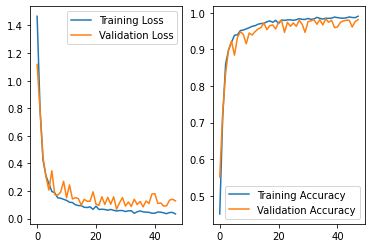

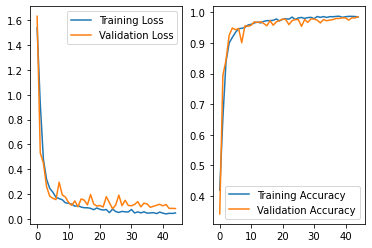

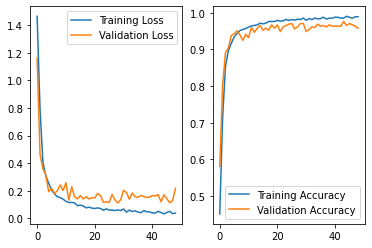

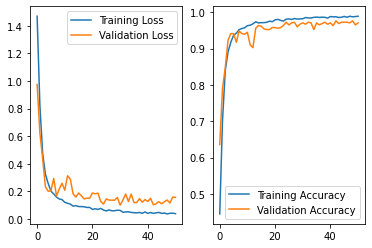

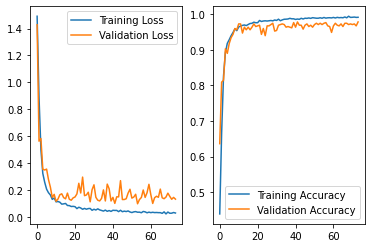

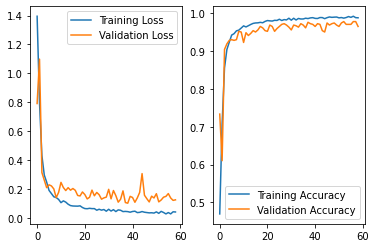

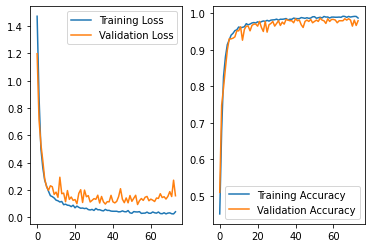

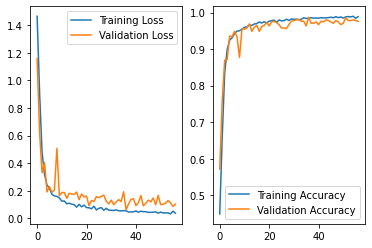

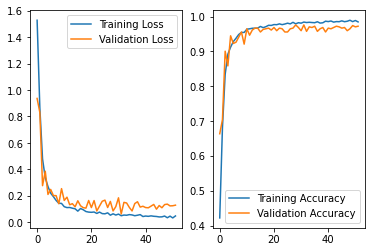

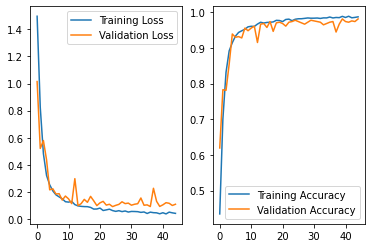

In [14]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [15]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.95087912 0.93426573 0.98003888 0.98511791 0.98161376
 0.91516484 0.97028656]
precision sdev by class [0.         0.06877409 0.07167065 0.02152739 0.01096595 0.02474959
 0.07455183 0.02447911]
macro precision mean 0.9646708497125891
macro precision sdev 0.00948688088010315
recall mean [0.93333333 0.97628205 0.90984848 0.96655172 0.98499747 0.96666667
 0.95833333 0.97268293]
recall sdev [0.2        0.03626755 0.0909375  0.03944204 0.00720014 0.01994505
 0.08539126 0.03043385]
macro recall mean 0.9585869994200908
macro recall sdev 0.026339636498893596
f1 mean [0.95       0.96114505 0.9171614  0.9727432  0.9850041  0.97393304
 0.93074303 0.97138197]
f1 sdev [0.15       0.03350801 0.05222791 0.02374543 0.00577472 0.01883125
 0.04280382 0.0258254 ]
macro f1 mean 0.9577639760438952
macro f1 sdev 0.02003364570892603
accuracy mean 0.9751468614551936
accuracy sdev 0.009046717746562927


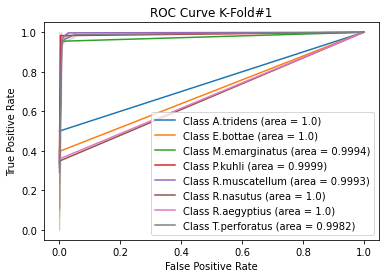

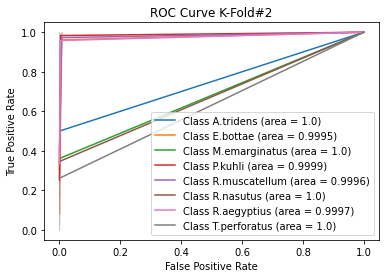

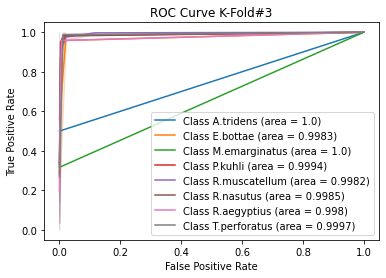

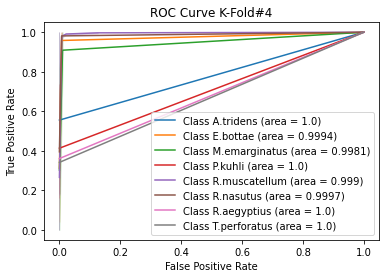

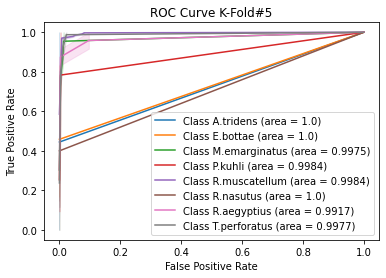

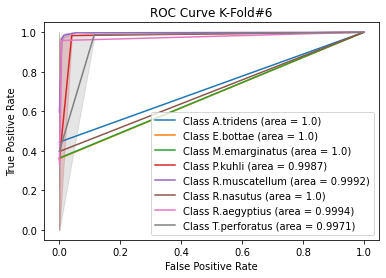

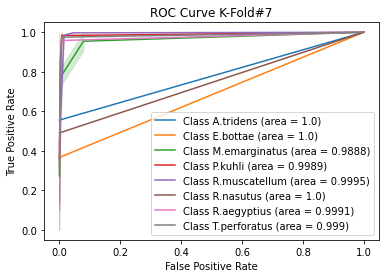

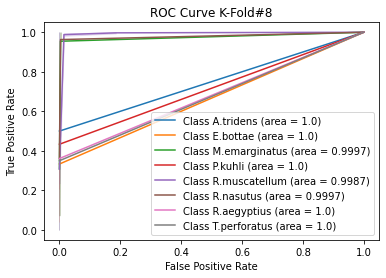

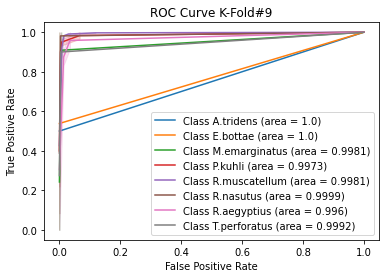

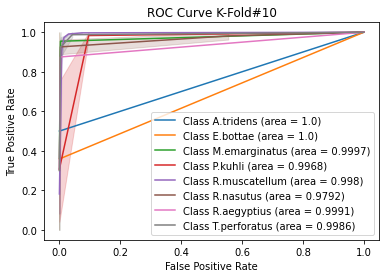

In [16]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [17]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9997168809792601
Std  0.0005277090025304329
Sp:  M.emarginatus
AUC Mean  0.9981248316797554
Std  0.003243521918043717
Sp:  P.kuhli
AUC Mean  0.9989190218723566
Std  0.001088258163528581
Sp:  R.muscatellum
AUC Mean  0.9988004725253014
Std  0.0005660833331284751
Sp:  R.nasutus
AUC Mean  0.9977028189436948
Std  0.00618798678714313
Sp:  R.aegyptius
AUC Mean  0.9983029073698445
Std  0.00250779382945464
Sp:  T.perforatus
AUC Mean  0.9989634182009102
Std  0.0009740138488832367


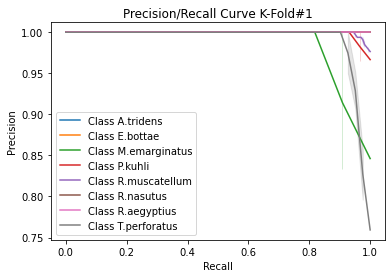

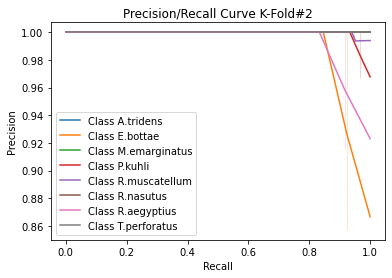

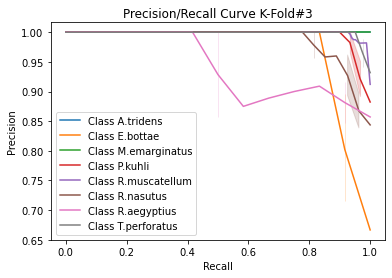

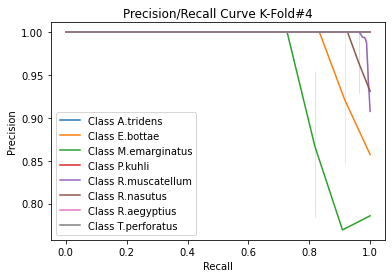

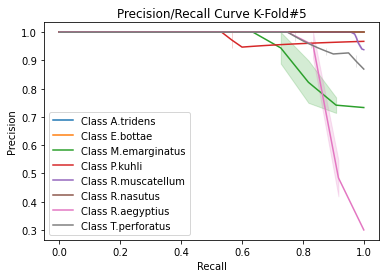

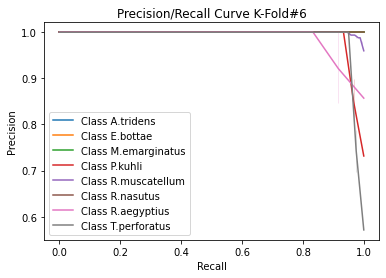

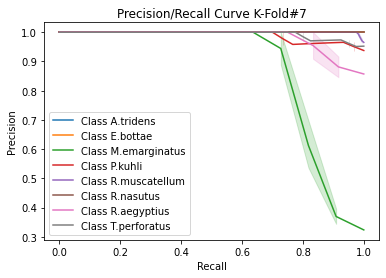

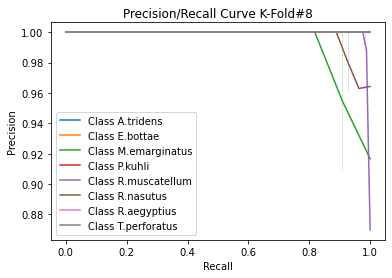

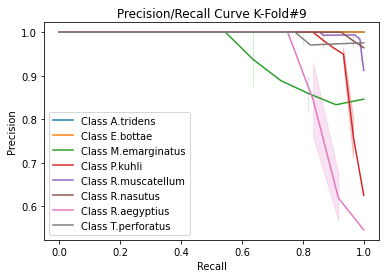

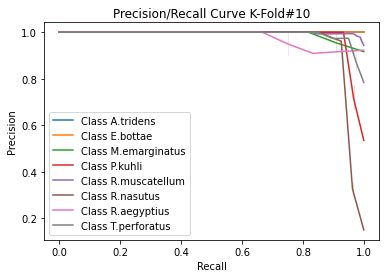

In [18]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1  10   0   0   0   0   0]
 [  0   0   0  28   1   0   0   0]
 [  0   0   1   0 163   0   0   2]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   1   0   0   0]
 [  0   0   1   0 164   0   1   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   0   0   0   1]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   1  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

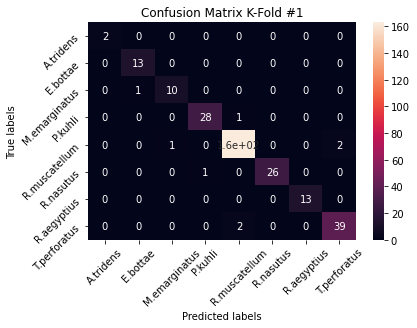

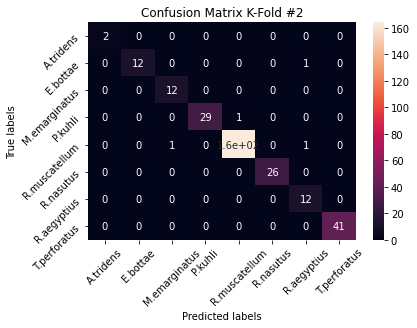

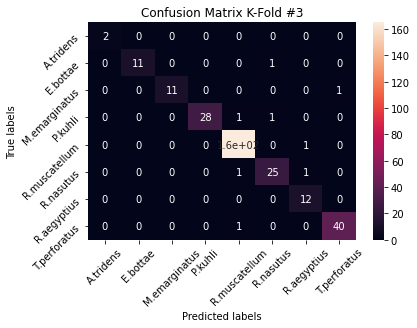

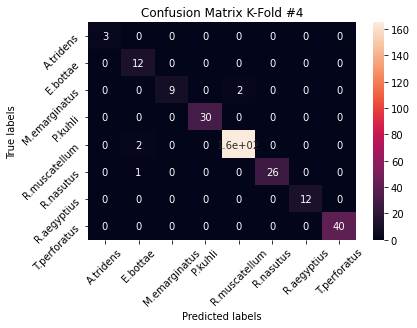

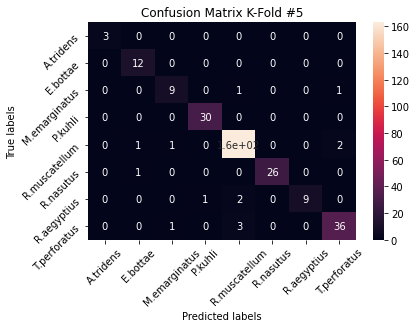

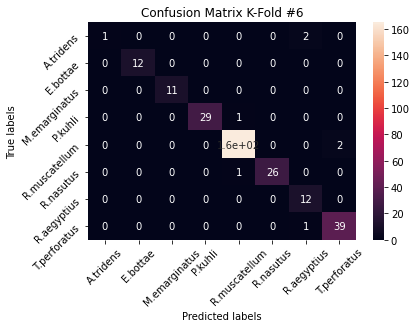

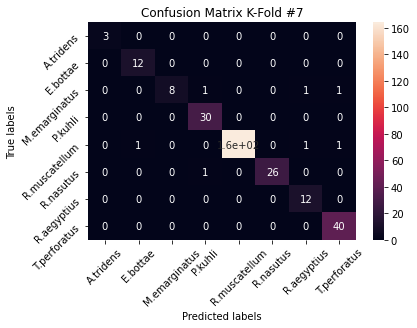

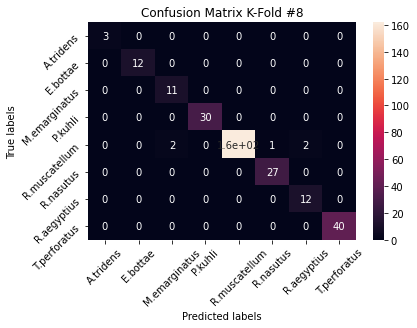

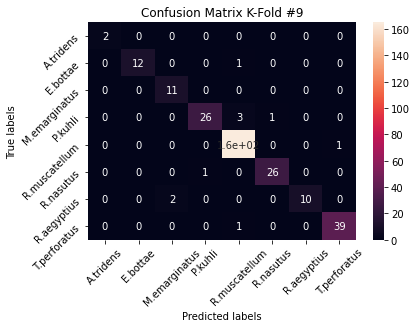

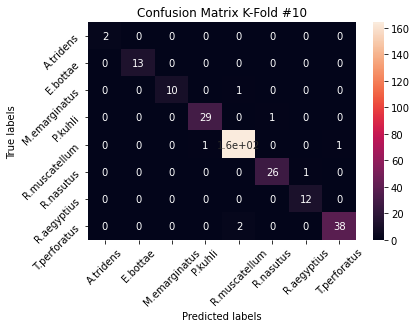

In [19]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  121    0    0    1    1    1    0]
 [   0    1  102    1    4    0    1    3]
 [   0    0    0  289    7    3    0    0]
 [   0    4    5    1 1640    1    5    9]
 [   0    2    0    3    2  260    2    0]
 [   0    0    2    1    2    0  116    0]
 [   0    0    1    0    9    0    1  392]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


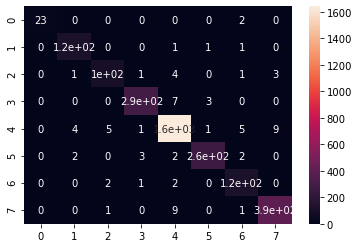

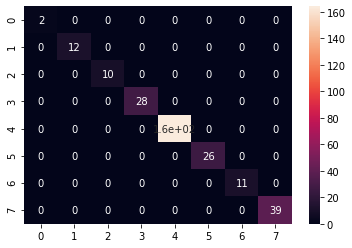

In [20]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.98 0.   0.   0.01 0.01 0.01 0.  ]
 [0.   0.01 0.91 0.01 0.04 0.   0.01 0.03]
 [0.   0.   0.   0.97 0.02 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.01 0.   0.01 0.01 0.97 0.01 0.  ]
 [0.   0.   0.02 0.01 0.02 0.   0.96 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.97]]


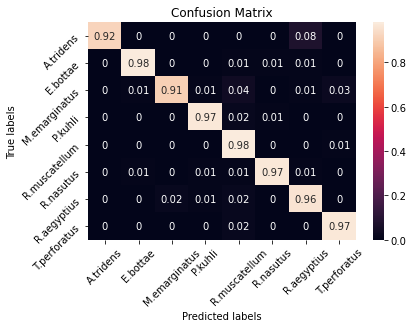

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V2 !!!!! K-Fold Training and Evaluation</h2>

In [22]:
folder = "models"
mode_version = "mel_smote_v2"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v2


In [23]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=248,kernel_size=(5,5),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [24]:
model = build_current_model()
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 56, 85, 120)       9120      
_________________________________________________________________
batch_normalization_55 (Batc (None, 56, 85, 120)       480       
_________________________________________________________________
activation_55 (Activation)   (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 22, 120)       360

In [25]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 8s - loss: 1.7436 - accuracy: 0.3372 - val_loss: 1.2203 - val_accuracy: 0.4945
Epoch 2/100
1199/1199 - 8s - loss: 1.3413 - accuracy: 0.4840 - val_loss: 0.8230 - val_accuracy: 0.6893
Epoch 3/100
1199/1199 - 8s - loss: 0.9239 - accuracy: 0.6748 - val_loss: 0.4714 - val_accuracy: 0.8290
Epoch 4/100
1199/1199 - 8s - loss: 0.5874 - accuracy: 0.8038 - val_loss: 0.3725 - val_accuracy: 0.8713
Epoch 5/100
1199/1199 - 8s - loss: 0.4194 - accuracy: 0.8638 - val_loss: 0.4089 - val_accuracy: 0.8787

Epoch 76/100
Restoring model weights from the end of the best epoch.
1199/1199 - 8s - loss: 0.0259 - accuracy: 0.9926 - val_loss: 0.1162 - val_accuracy: 0.9761
Epoch 00076: early stopping
models/mel_smote_v2_iter_1.model
INFO:tensorflow:Assets written to: models/mel_smote_v2_iter_1.model/assets
Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 87), ('T.perforatus', 290), ('P.kuhli', 215), ('A.tridens', 18), ('M.emarginatus', 80)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 8s - loss: 1.7159 - accuracy: 0.3574 - val_loss: 1.0999 - val_accuracy: 0.5386
Epoch 2/100
1199/1199 - 8s - loss: 1.2303 - accuracy: 0.5458 - val_loss: 0.8184 - val_accuracy: 0.6912
Epoch 3/100


Epoch 6/100
1199/1199 - 8s - loss: 0.2772 - accuracy: 0.9140 - val_loss: 0.3278 - val_accuracy: 0.9118
Epoch 7/100
1199/1199 - 8s - loss: 0.2278 - accuracy: 0.9318 - val_loss: 0.1946 - val_accuracy: 0.9375
Epoch 8/100
1199/1199 - 8s - loss: 0.2058 - accuracy: 0.9363 - val_loss: 0.1676 - val_accuracy: 0.9467
Epoch 9/100
1199/1199 - 8s - loss: 0.1696 - accuracy: 0.9474 - val_loss: 0.2267 - val_accuracy: 0.9430
Epoch 10/100
1199/1199 - 8s - loss: 0.1563 - accuracy: 0.9532 - val_loss: 0.1657 - val_accuracy: 0.9467
Epoch 11/100
1199/1199 - 8s - loss: 0.1378 - accuracy: 0.9593 - val_loss: 0.2318 - val_accuracy: 0.9393
Epoch 12/100
1199/1199 - 8s - loss: 0.1294 - accuracy: 0.9600 - val_loss: 0.1691 - val_accuracy: 0.9449
Epoch 13/100
1199/1199 - 8s - loss: 0.1119 - accuracy: 0.9672 - val_loss: 0.1745 - val_accuracy: 0.9522
Epoch 14/100
1199/1199 - 8s - loss: 0.1140 - accuracy: 0.9663 - val_loss: 0.1626 - val_accuracy: 0.9485
Epoch 15/100
1199/1199 - 8s - loss: 0.0958 - accuracy: 0.9704 - val_

Epoch 20/100
1198/1198 - 8s - loss: 0.0763 - accuracy: 0.9781 - val_loss: 0.1695 - val_accuracy: 0.9577
Epoch 21/100
1198/1198 - 8s - loss: 0.0694 - accuracy: 0.9787 - val_loss: 0.1145 - val_accuracy: 0.9651
Epoch 22/100
1198/1198 - 8s - loss: 0.0794 - accuracy: 0.9751 - val_loss: 0.1166 - val_accuracy: 0.9632
Epoch 23/100
1198/1198 - 8s - loss: 0.0623 - accuracy: 0.9817 - val_loss: 0.1136 - val_accuracy: 0.9688
Epoch 24/100
1198/1198 - 8s - loss: 0.0724 - accuracy: 0.9788 - val_loss: 0.1630 - val_accuracy: 0.9669
Epoch 25/100
1198/1198 - 8s - loss: 0.0590 - accuracy: 0.9838 - val_loss: 0.1454 - val_accuracy: 0.9559
Epoch 26/100
1198/1198 - 8s - loss: 0.0571 - accuracy: 0.9828 - val_loss: 0.2432 - val_accuracy: 0.9467
Epoch 27/100
1198/1198 - 8s - loss: 0.0662 - accuracy: 0.9804 - val_loss: 0.1270 - val_accuracy: 0.9706
Epoch 28/100
1198/1198 - 8s - loss: 0.0562 - accuracy: 0.9837 - val_loss: 0.1051 - val_accuracy: 0.9669
Epoch 29/100
1198/1198 - 8s - loss: 0.0548 - accuracy: 0.9834 - 

Epoch 45/100
1198/1198 - 8s - loss: 0.0353 - accuracy: 0.9901 - val_loss: 0.1747 - val_accuracy: 0.9632
Epoch 46/100
1198/1198 - 8s - loss: 0.0398 - accuracy: 0.9895 - val_loss: 0.2572 - val_accuracy: 0.9632
Epoch 47/100
1198/1198 - 8s - loss: 0.0321 - accuracy: 0.9914 - val_loss: 0.3656 - val_accuracy: 0.9504
Epoch 48/100
1198/1198 - 8s - loss: 0.0372 - accuracy: 0.9909 - val_loss: 0.1859 - val_accuracy: 0.9596
Epoch 49/100
1198/1198 - 8s - loss: 0.0332 - accuracy: 0.9907 - val_loss: 0.2256 - val_accuracy: 0.9614
Epoch 50/100
1198/1198 - 8s - loss: 0.0326 - accuracy: 0.9910 - val_loss: 0.1748 - val_accuracy: 0.9614
Epoch 51/100
1198/1198 - 8s - loss: 0.0387 - accuracy: 0.9899 - val_loss: 0.1885 - val_accuracy: 0.9614
Epoch 52/100
1198/1198 - 8s - loss: 0.0372 - accuracy: 0.9895 - val_loss: 0.1276 - val_accuracy: 0.9706
Epoch 53/100
1198/1198 - 8s - loss: 0.0406 - accuracy: 0.9898 - val_loss: 0.2274 - val_accuracy: 0.9669
Epoch 54/100
1198/1198 - 8s - loss: 0.0317 - accuracy: 0.9926 - 

Epoch 8/100
1198/1198 - 8s - loss: 0.2040 - accuracy: 0.9421 - val_loss: 0.2314 - val_accuracy: 0.9283
Epoch 9/100
1198/1198 - 8s - loss: 0.1689 - accuracy: 0.9495 - val_loss: 0.1452 - val_accuracy: 0.9467
Epoch 10/100
1198/1198 - 8s - loss: 0.1620 - accuracy: 0.9517 - val_loss: 0.1773 - val_accuracy: 0.9449
Epoch 11/100
1198/1198 - 8s - loss: 0.1548 - accuracy: 0.9521 - val_loss: 0.1968 - val_accuracy: 0.9412
Epoch 12/100
1198/1198 - 8s - loss: 0.1280 - accuracy: 0.9630 - val_loss: 0.2170 - val_accuracy: 0.9320
Epoch 13/100
1198/1198 - 8s - loss: 0.1242 - accuracy: 0.9655 - val_loss: 0.1829 - val_accuracy: 0.9504
Epoch 14/100
1198/1198 - 8s - loss: 0.1083 - accuracy: 0.9677 - val_loss: 0.2351 - val_accuracy: 0.9357
Epoch 15/100
1198/1198 - 8s - loss: 0.0951 - accuracy: 0.9723 - val_loss: 0.0958 - val_accuracy: 0.9743
Epoch 16/100
1198/1198 - 8s - loss: 0.0902 - accuracy: 0.9746 - val_loss: 0.1202 - val_accuracy: 0.9688
Epoch 17/100
1198/1198 - 8s - loss: 0.0936 - accuracy: 0.9731 - va

Epoch 28/100
1198/1198 - 8s - loss: 0.0517 - accuracy: 0.9853 - val_loss: 0.0922 - val_accuracy: 0.9724
Epoch 29/100
1198/1198 - 8s - loss: 0.0641 - accuracy: 0.9823 - val_loss: 0.1246 - val_accuracy: 0.9688
Epoch 30/100
1198/1198 - 8s - loss: 0.0524 - accuracy: 0.9856 - val_loss: 0.1496 - val_accuracy: 0.9724
Epoch 31/100
1198/1198 - 8s - loss: 0.0509 - accuracy: 0.9846 - val_loss: 0.0923 - val_accuracy: 0.9798
Epoch 32/100
1198/1198 - 8s - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.1199 - val_accuracy: 0.9724
Epoch 33/100
1198/1198 - 8s - loss: 0.0460 - accuracy: 0.9874 - val_loss: 0.0823 - val_accuracy: 0.9761
Epoch 34/100
1198/1198 - 8s - loss: 0.0475 - accuracy: 0.9866 - val_loss: 0.1060 - val_accuracy: 0.9743
Epoch 35/100
1198/1198 - 8s - loss: 0.0442 - accuracy: 0.9875 - val_loss: 0.1064 - val_accuracy: 0.9688
Epoch 36/100
1198/1198 - 8s - loss: 0.0442 - accuracy: 0.9878 - val_loss: 0.0990 - val_accuracy: 0.9706
Epoch 37/100
1198/1198 - 8s - loss: 0.0439 - accuracy: 0.9879 - 

Epoch 48/100
1199/1199 - 8s - loss: 0.0397 - accuracy: 0.9894 - val_loss: 0.1353 - val_accuracy: 0.9651
Epoch 49/100
1199/1199 - 8s - loss: 0.0365 - accuracy: 0.9900 - val_loss: 0.1468 - val_accuracy: 0.9632
Epoch 50/100
1199/1199 - 8s - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.1316 - val_accuracy: 0.9669
Epoch 51/100
1199/1199 - 8s - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.1166 - val_accuracy: 0.9669
Epoch 52/100
1199/1199 - 8s - loss: 0.0388 - accuracy: 0.9898 - val_loss: 0.1358 - val_accuracy: 0.9724
Epoch 53/100
1199/1199 - 8s - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.1823 - val_accuracy: 0.9522
Epoch 54/100
1199/1199 - 8s - loss: 0.0287 - accuracy: 0.9924 - val_loss: 0.1451 - val_accuracy: 0.9688
Epoch 55/100
1199/1199 - 8s - loss: 0.0321 - accuracy: 0.9912 - val_loss: 0.3827 - val_accuracy: 0.9210
Epoch 56/100
1199/1199 - 8s - loss: 0.0338 - accuracy: 0.9920 - val_loss: 0.0876 - val_accuracy: 0.9761
Epoch 57/100
1199/1199 - 8s - loss: 0.0334 - accuracy: 0.9910 - 

## LOAD AND EVAL

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [27]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
   
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

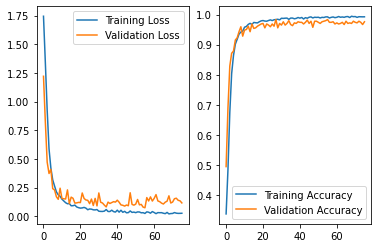

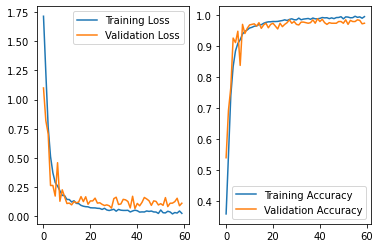

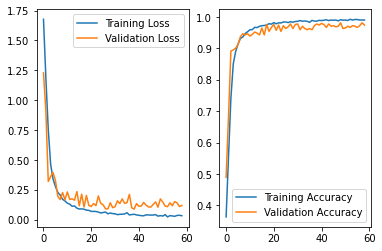

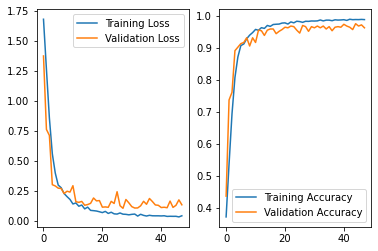

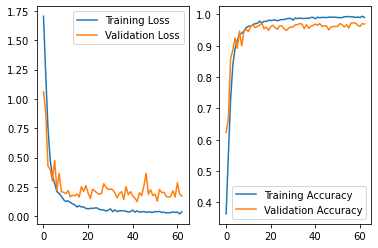

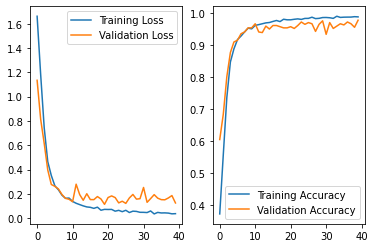

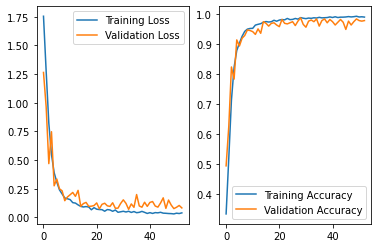

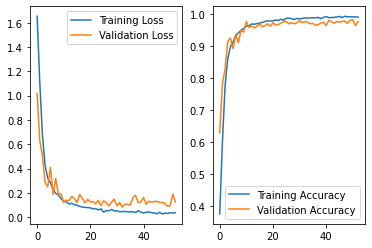

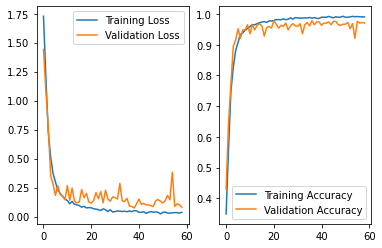

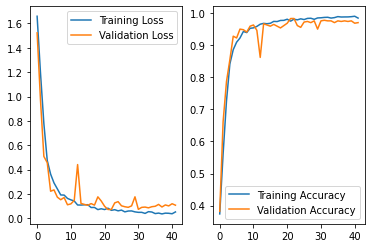

In [28]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [29]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.9768315  0.91059774 0.96772108 0.98444423 0.97008547
 0.88700133 0.96892552]
precision sdev by class [0.         0.03549064 0.09306266 0.04065496 0.00603304 0.02779786
 0.05808324 0.03702519]
macro precision mean 0.9582008583117749
macro precision sdev 0.01969413966678785
recall mean [0.96666667 0.96666667 0.91818182 0.94988506 0.98679749 0.95185185
 0.95833333 0.95768293]
recall sdev [0.1        0.05527708 0.08576346 0.04277407 0.00837401 0.02371527
 0.07682954 0.02750831]
macro recall mean 0.9570082262949378
macro recall sdev 0.02140508253557026
f1 mean [0.98       0.97052423 0.9113907  0.95786287 0.98559969 0.96079665
 0.91972811 0.96267726]
f1 sdev [0.06       0.0337384  0.07326244 0.03084569 0.00584275 0.02413371
 0.05737543 0.02258538]
macro f1 mean 0.9560724361301217
macro f1 sdev 0.018797125845983656
accuracy mean 0.9715000770060064
accuracy sdev 0.011114705447291122


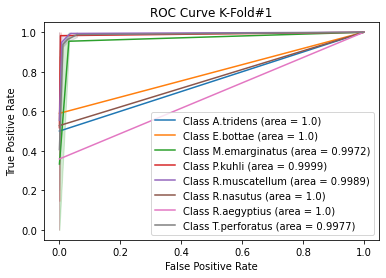

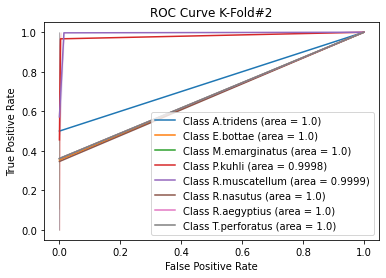

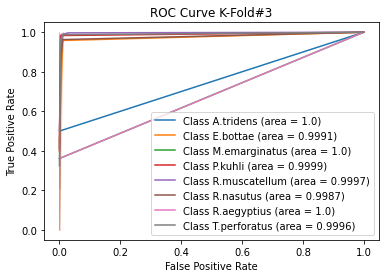

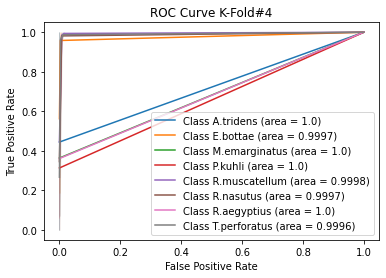

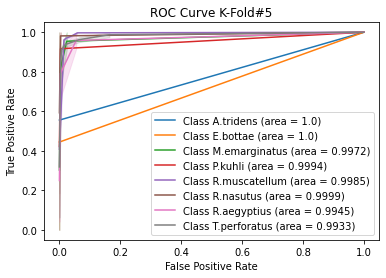

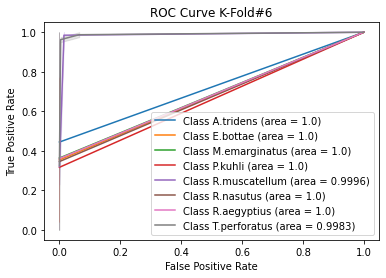

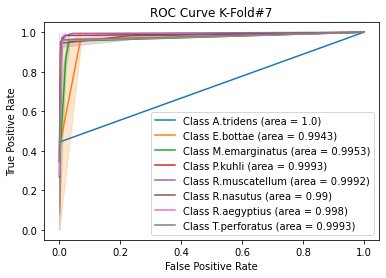

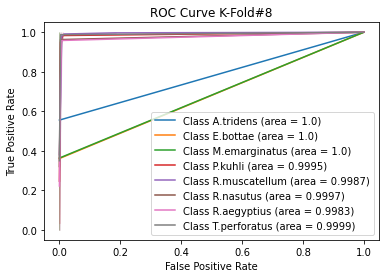

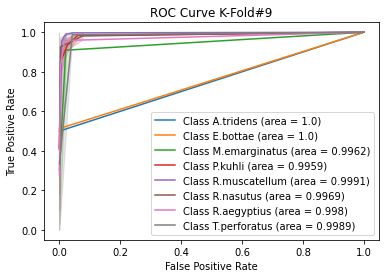

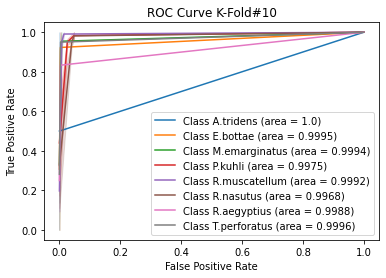

In [30]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [31]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9992569260241675
Std  0.0016917141117114458
Sp:  M.emarginatus
AUC Mean  0.9985302006915943
Std  0.00175243092234871
Sp:  P.kuhli
AUC Mean  0.9991148741985268
Std  0.0012625571884126191
Sp:  R.muscatellum
AUC Mean  0.9992540360259087
Std  0.00045970419763441807
Sp:  R.nasutus
AUC Mean  0.9981660399616604
Std  0.002964129484500918
Sp:  R.aegyptius
AUC Mean  0.9987632740723063
Std  0.0016412628059684353
Sp:  T.perforatus
AUC Mean  0.9986311206557709
Std  0.0019047707178182491


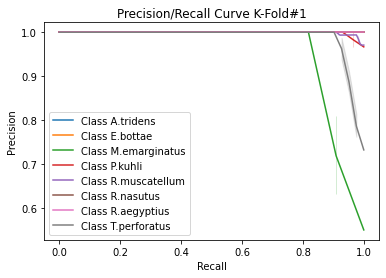

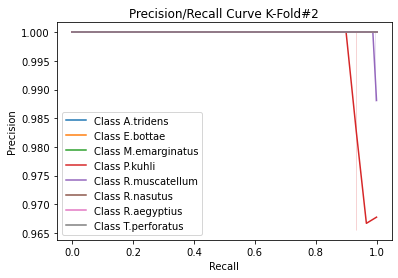

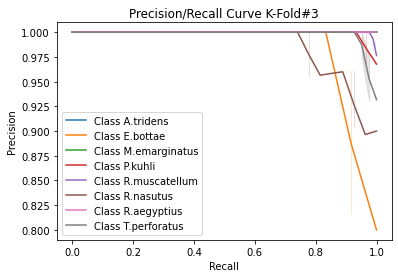

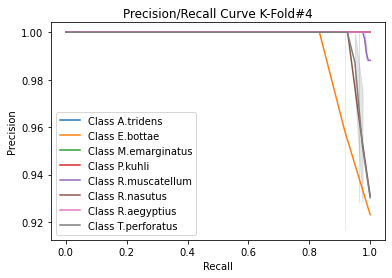

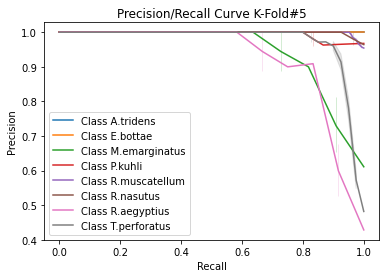

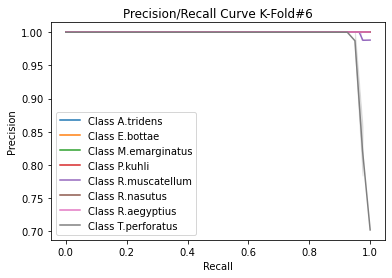

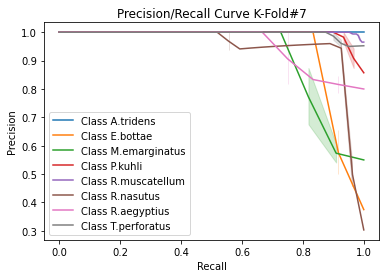

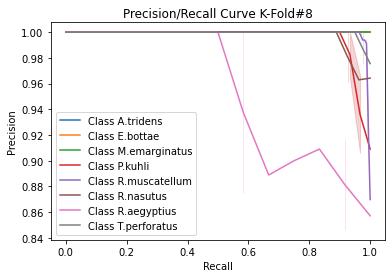

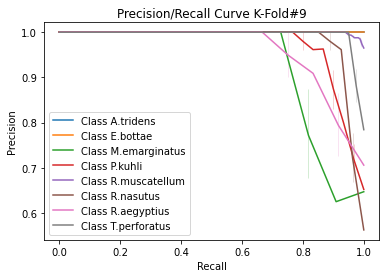

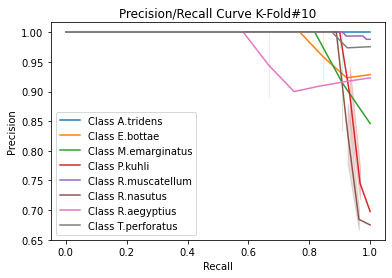

In [32]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   9   0   0   0   1   1]
 [  0   0   0  28   1   0   0   0]
 [  0   0   0   0 164   0   0   2]
 [  0   0   0   0   1  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   1  28   1   0   0   0]
 [  0   0   1   0 165   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   1   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   1   0   1  25   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

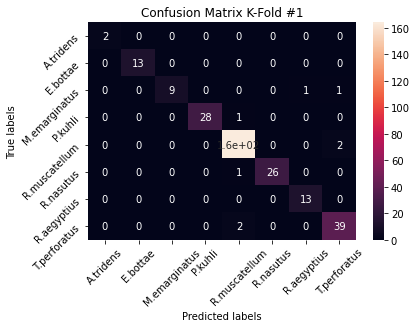

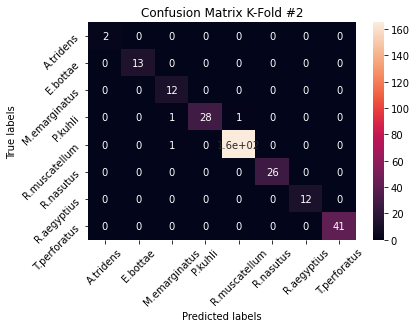

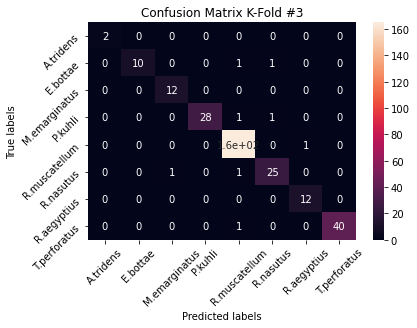

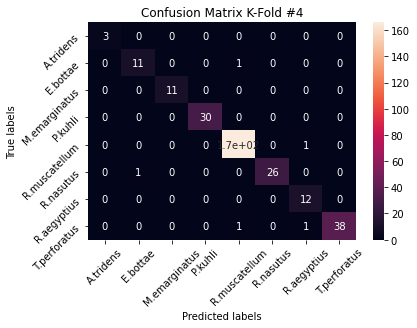

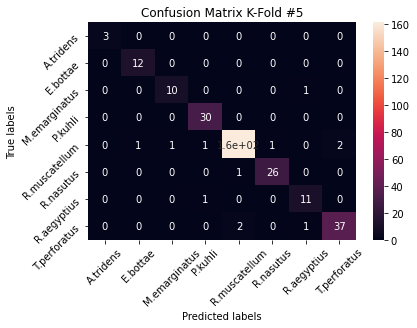

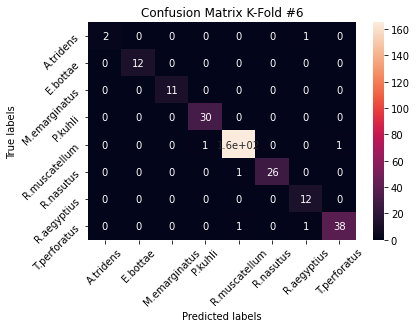

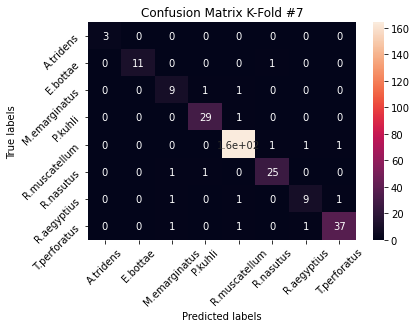

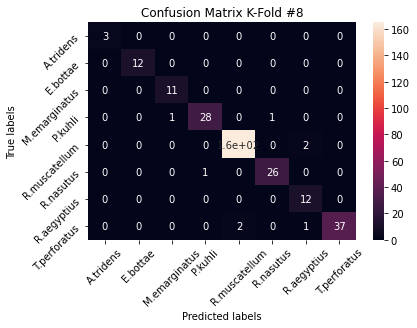

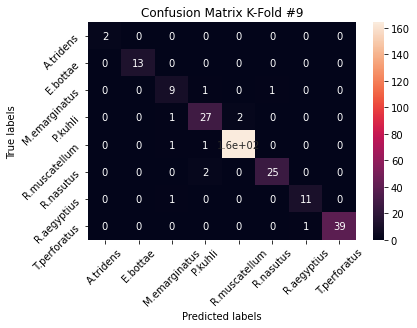

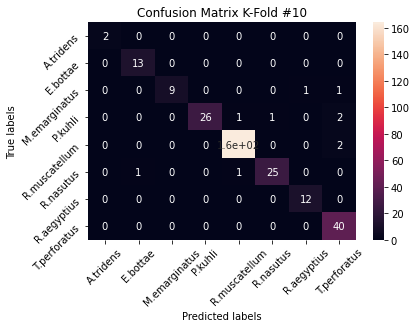

In [33]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  120    0    0    2    2    0    0]
 [   0    0  103    2    1    1    3    2]
 [   0    0    3  284    7    3    0    2]
 [   0    1    3    3 1643    2    5    8]
 [   0    2    2    4    5  256    0    0]
 [   0    0    2    1    1    0  116    1]
 [   0    0    1    0   10    0    6  386]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


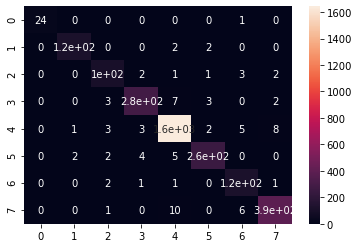

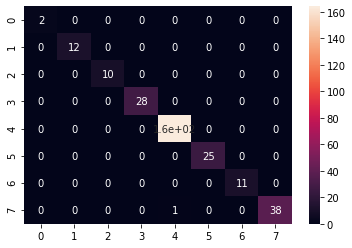

In [34]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.97 0.   0.   0.02 0.02 0.   0.  ]
 [0.   0.   0.92 0.02 0.01 0.01 0.03 0.02]
 [0.   0.   0.01 0.95 0.02 0.01 0.   0.01]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.02 0.95 0.   0.  ]
 [0.   0.   0.02 0.01 0.01 0.   0.96 0.01]
 [0.   0.   0.   0.   0.02 0.   0.01 0.96]]


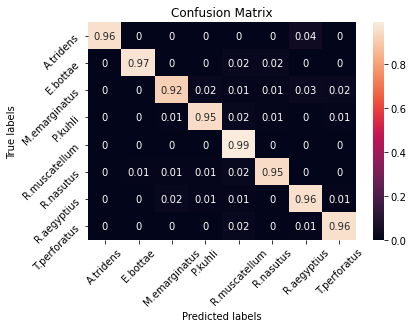

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V3 !!!!! K-Fold Training and Evaluation</h2>

In [36]:
folder = "models"
mode_version = "mel_smote_v3"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v3


In [37]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=152,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [38]:
model = build_current_model()
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_132 (Bat (None, 56, 85, 120)       480       
_________________________________________________________________
activation_132 (Activation)  (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_132 (Dropout)        (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 14, 22, 152)       456

In [39]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 8s - loss: 1.6729 - accuracy: 0.3724 - val_loss: 1.3894 - val_accuracy: 0.4853
Epoch 2/100
1199/1199 - 8s - loss: 1.2688 - accuracy: 0.5246 - val_loss: 0.9537 - val_accuracy: 0.6379
Epoch 3/100
1199/1199 - 8s - loss: 0.8509 - accuracy: 0.6871 - val_loss: 0.4694 - val_accuracy: 0.8217
Epoch 4/100
1199/1199 - 9s - loss: 0.5211 - accuracy: 0.8284 - val_loss: 0.2626 - val_accuracy: 0.9062
Epoch 5/100
1199/1199 - 9s - loss: 0.3707 - accuracy: 0.8822 - val_loss: 0.2948 - val_accuracy: 0.9044

Epoch 4/100
1199/1199 - 9s - loss: 0.5324 - accuracy: 0.8256 - val_loss: 0.5539 - val_accuracy: 0.8474
Epoch 5/100
1199/1199 - 9s - loss: 0.4016 - accuracy: 0.8691 - val_loss: 0.3549 - val_accuracy: 0.8842
Epoch 6/100
1199/1199 - 9s - loss: 0.2988 - accuracy: 0.9072 - val_loss: 0.2036 - val_accuracy: 0.9357
Epoch 7/100
1199/1199 - 9s - loss: 0.2514 - accuracy: 0.9224 - val_loss: 0.2245 - val_accuracy: 0.9228
Epoch 8/100
1199/1199 - 9s - loss: 0.2152 - accuracy: 0.9353 - val_loss: 0.2694 - val_accuracy: 0.9265
Epoch 9/100
1199/1199 - 9s - loss: 0.1825 - accuracy: 0.9459 - val_loss: 0.2042 - val_accuracy: 0.9485
Epoch 10/100
1199/1199 - 9s - loss: 0.1749 - accuracy: 0.9472 - val_loss: 0.1659 - val_accuracy: 0.9485
Epoch 11/100
1199/1199 - 9s - loss: 0.1491 - accuracy: 0.9539 - val_loss: 0.1337 - val_accuracy: 0.9632
Epoch 12/100
1199/1199 - 9s - loss: 0.1283 - accuracy: 0.9606 - val_loss: 0.1250 - val_accuracy: 0.9779
Epoch 13/100
1199/1199 - 9s - loss: 0.1131 - accuracy: 0.9652 - val_lo

Epoch 38/100
1199/1199 - 9s - loss: 0.0420 - accuracy: 0.9893 - val_loss: 0.1059 - val_accuracy: 0.9761
Epoch 39/100
1199/1199 - 9s - loss: 0.0459 - accuracy: 0.9878 - val_loss: 0.1143 - val_accuracy: 0.9761
Epoch 40/100
1199/1199 - 9s - loss: 0.0524 - accuracy: 0.9863 - val_loss: 0.0952 - val_accuracy: 0.9743
Epoch 41/100
1199/1199 - 9s - loss: 0.0444 - accuracy: 0.9878 - val_loss: 0.1708 - val_accuracy: 0.9632
Epoch 42/100
1199/1199 - 9s - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.1261 - val_accuracy: 0.9724
Epoch 43/100
1199/1199 - 9s - loss: 0.0445 - accuracy: 0.9875 - val_loss: 0.1369 - val_accuracy: 0.9651
Epoch 44/100
1199/1199 - 9s - loss: 0.0467 - accuracy: 0.9868 - val_loss: 0.0724 - val_accuracy: 0.9779
Epoch 45/100
1199/1199 - 9s - loss: 0.0359 - accuracy: 0.9906 - val_loss: 0.0927 - val_accuracy: 0.9761
Epoch 46/100
1199/1199 - 9s - loss: 0.0493 - accuracy: 0.9864 - val_loss: 0.1263 - val_accuracy: 0.9577
Epoch 47/100
1199/1199 - 9s - loss: 0.0366 - accuracy: 0.9901 - 

Epoch 47/100
1198/1198 - 9s - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.0937 - val_accuracy: 0.9798
Epoch 48/100
1198/1198 - 9s - loss: 0.0408 - accuracy: 0.9905 - val_loss: 0.1185 - val_accuracy: 0.9724
Epoch 49/100
1198/1198 - 9s - loss: 0.0395 - accuracy: 0.9888 - val_loss: 0.0959 - val_accuracy: 0.9724
Epoch 50/100
1198/1198 - 9s - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.1298 - val_accuracy: 0.9706
Epoch 51/100
1198/1198 - 9s - loss: 0.0395 - accuracy: 0.9885 - val_loss: 0.1351 - val_accuracy: 0.9596
Epoch 52/100
1198/1198 - 9s - loss: 0.0442 - accuracy: 0.9886 - val_loss: 0.1370 - val_accuracy: 0.9669
Epoch 53/100
1198/1198 - 9s - loss: 0.0356 - accuracy: 0.9901 - val_loss: 0.1449 - val_accuracy: 0.9669
Epoch 54/100
1198/1198 - 9s - loss: 0.0286 - accuracy: 0.9921 - val_loss: 0.1737 - val_accuracy: 0.9669
Epoch 55/100
1198/1198 - 9s - loss: 0.0372 - accuracy: 0.9896 - val_loss: 0.1543 - val_accuracy: 0.9724
Epoch 56/100
1198/1198 - 9s - loss: 0.0374 - accuracy: 0.9900 - 

Epoch 24/100
1198/1198 - 9s - loss: 0.0617 - accuracy: 0.9822 - val_loss: 0.1256 - val_accuracy: 0.9743
Epoch 25/100
1198/1198 - 9s - loss: 0.0721 - accuracy: 0.9798 - val_loss: 0.1639 - val_accuracy: 0.9688
Epoch 26/100
1198/1198 - 9s - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.1358 - val_accuracy: 0.9724
Epoch 27/100
1198/1198 - 9s - loss: 0.0621 - accuracy: 0.9830 - val_loss: 0.1412 - val_accuracy: 0.9651
Epoch 28/100
1198/1198 - 9s - loss: 0.0635 - accuracy: 0.9824 - val_loss: 0.1226 - val_accuracy: 0.9724
Epoch 29/100
1198/1198 - 9s - loss: 0.0507 - accuracy: 0.9846 - val_loss: 0.1026 - val_accuracy: 0.9724
Epoch 30/100
1198/1198 - 9s - loss: 0.0575 - accuracy: 0.9828 - val_loss: 0.1754 - val_accuracy: 0.9596
Epoch 31/100
1198/1198 - 9s - loss: 0.0521 - accuracy: 0.9851 - val_loss: 0.0939 - val_accuracy: 0.9798
Epoch 32/100
1198/1198 - 9s - loss: 0.0602 - accuracy: 0.9847 - val_loss: 0.1247 - val_accuracy: 0.9779
Epoch 33/100
1198/1198 - 9s - loss: 0.0384 - accuracy: 0.9881 - 

Epoch 46/100
1198/1198 - 9s - loss: 0.0408 - accuracy: 0.9900 - val_loss: 0.1093 - val_accuracy: 0.9761
Epoch 47/100
1198/1198 - 9s - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.1484 - val_accuracy: 0.9706
Epoch 48/100
1198/1198 - 9s - loss: 0.0394 - accuracy: 0.9896 - val_loss: 0.1193 - val_accuracy: 0.9761
Epoch 49/100
1198/1198 - 9s - loss: 0.0434 - accuracy: 0.9881 - val_loss: 0.1789 - val_accuracy: 0.9632
Epoch 50/100
1198/1198 - 9s - loss: 0.0327 - accuracy: 0.9904 - val_loss: 0.1807 - val_accuracy: 0.9632
Epoch 51/100
1198/1198 - 9s - loss: 0.0354 - accuracy: 0.9908 - val_loss: 0.1723 - val_accuracy: 0.9632
Epoch 52/100
Restoring model weights from the end of the best epoch.
1198/1198 - 9s - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.1219 - val_accuracy: 0.9743
Epoch 00052: early stopping
models/mel_smote_v3_iter_6.model
INFO:tensorflow:Assets written to: models/mel_smote_v3_iter_6.model/assets
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.

Epoch 5/100
1198/1198 - 9s - loss: 0.3680 - accuracy: 0.8831 - val_loss: 0.2686 - val_accuracy: 0.9044
Epoch 6/100
1198/1198 - 9s - loss: 0.2934 - accuracy: 0.9068 - val_loss: 0.3621 - val_accuracy: 0.8971
Epoch 7/100
1198/1198 - 9s - loss: 0.2559 - accuracy: 0.9198 - val_loss: 0.2222 - val_accuracy: 0.9338
Epoch 8/100
1198/1198 - 9s - loss: 0.1974 - accuracy: 0.9394 - val_loss: 0.1745 - val_accuracy: 0.9485
Epoch 9/100
1198/1198 - 9s - loss: 0.1875 - accuracy: 0.9446 - val_loss: 0.1301 - val_accuracy: 0.9540
Epoch 10/100
1198/1198 - 9s - loss: 0.1611 - accuracy: 0.9509 - val_loss: 0.2201 - val_accuracy: 0.9265
Epoch 11/100
1198/1198 - 9s - loss: 0.1279 - accuracy: 0.9610 - val_loss: 0.1260 - val_accuracy: 0.9651
Epoch 12/100
1198/1198 - 9s - loss: 0.1331 - accuracy: 0.9612 - val_loss: 0.1819 - val_accuracy: 0.9522
Epoch 13/100
1198/1198 - 9s - loss: 0.1296 - accuracy: 0.9638 - val_loss: 0.1332 - val_accuracy: 0.9596
Epoch 14/100
1198/1198 - 9s - loss: 0.1144 - accuracy: 0.9678 - val_l

Epoch 6/100
1199/1199 - 9s - loss: 0.2985 - accuracy: 0.9048 - val_loss: 0.2718 - val_accuracy: 0.9246
Epoch 7/100
1199/1199 - 9s - loss: 0.2651 - accuracy: 0.9146 - val_loss: 0.1783 - val_accuracy: 0.9357
Epoch 8/100
1199/1199 - 9s - loss: 0.2222 - accuracy: 0.9312 - val_loss: 0.2784 - val_accuracy: 0.8971
Epoch 9/100
1199/1199 - 9s - loss: 0.1932 - accuracy: 0.9396 - val_loss: 0.1802 - val_accuracy: 0.9430
Epoch 10/100
1199/1199 - 9s - loss: 0.1606 - accuracy: 0.9517 - val_loss: 0.1531 - val_accuracy: 0.9632
Epoch 11/100
1199/1199 - 9s - loss: 0.1640 - accuracy: 0.9525 - val_loss: 0.2242 - val_accuracy: 0.9357
Epoch 12/100
1199/1199 - 9s - loss: 0.1300 - accuracy: 0.9628 - val_loss: 0.1228 - val_accuracy: 0.9632
Epoch 13/100
1199/1199 - 9s - loss: 0.1328 - accuracy: 0.9599 - val_loss: 0.1776 - val_accuracy: 0.9393
Epoch 14/100
1199/1199 - 9s - loss: 0.1158 - accuracy: 0.9642 - val_loss: 0.1046 - val_accuracy: 0.9669
Epoch 15/100
1199/1199 - 9s - loss: 0.1063 - accuracy: 0.9691 - val_

Epoch 34/100
1199/1199 - 9s - loss: 0.0464 - accuracy: 0.9852 - val_loss: 0.1281 - val_accuracy: 0.9688
Epoch 35/100
1199/1199 - 9s - loss: 0.0438 - accuracy: 0.9881 - val_loss: 0.0925 - val_accuracy: 0.9761
Epoch 36/100
1199/1199 - 9s - loss: 0.0507 - accuracy: 0.9855 - val_loss: 0.1546 - val_accuracy: 0.9651
Epoch 37/100
1199/1199 - 9s - loss: 0.0436 - accuracy: 0.9877 - val_loss: 0.1148 - val_accuracy: 0.9724
Epoch 38/100
1199/1199 - 9s - loss: 0.0496 - accuracy: 0.9864 - val_loss: 0.0857 - val_accuracy: 0.9798
Epoch 39/100
1199/1199 - 9s - loss: 0.0466 - accuracy: 0.9879 - val_loss: 0.1211 - val_accuracy: 0.9779
Epoch 40/100
1199/1199 - 9s - loss: 0.0436 - accuracy: 0.9875 - val_loss: 0.0524 - val_accuracy: 0.9871
Epoch 41/100
1199/1199 - 9s - loss: 0.0394 - accuracy: 0.9885 - val_loss: 0.0723 - val_accuracy: 0.9761
Epoch 42/100
1199/1199 - 9s - loss: 0.0487 - accuracy: 0.9860 - val_loss: 0.1281 - val_accuracy: 0.9688
Epoch 43/100
1199/1199 - 9s - loss: 0.0398 - accuracy: 0.9897 - 

## Load and Eval

In [40]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [41]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

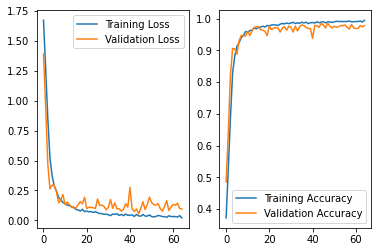

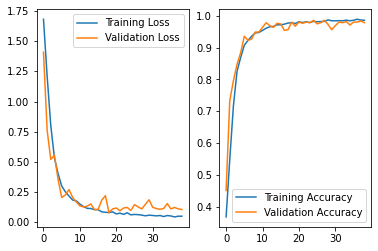

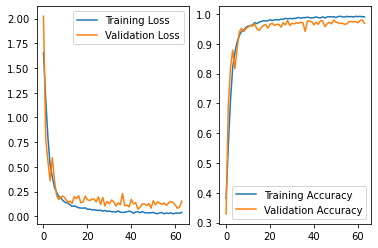

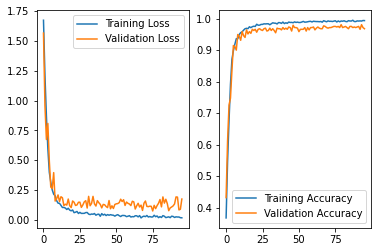

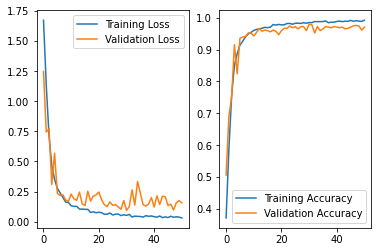

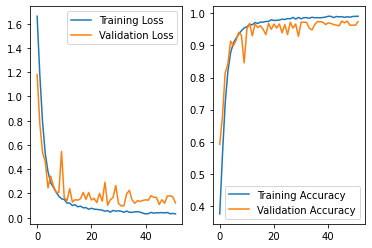

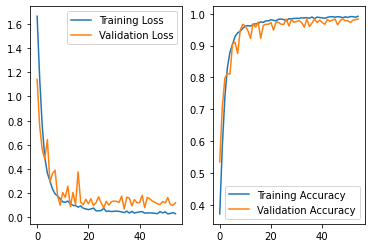

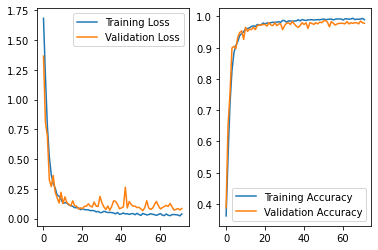

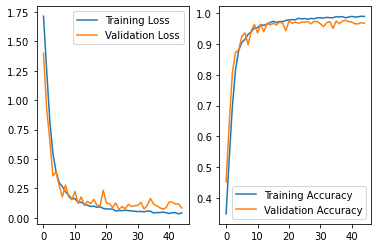

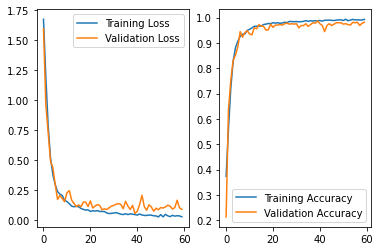

In [42]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [43]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.94747253 0.91289821 0.96176064 0.990346   0.97789988
 0.8807281  0.96568517]
precision sdev by class [0.         0.04583849 0.09176998 0.03791315 0.00676078 0.02450483
 0.09305039 0.03044973]
macro precision mean 0.9545988153880403
macro precision sdev 0.021707548689556433
recall mean [0.96666667 0.96025641 0.89090909 0.96666667 0.98678667 0.96282051
 0.93333333 0.9652439 ]
recall sdev [0.1        0.05261099 0.09791209 0.02981424 0.01134189 0.02342818
 0.06236096 0.02760249]
macro recall mean 0.9540854063400379
macro recall sdev 0.017351431407522468
f1 mean [0.98       0.95247228 0.89953059 0.96351734 0.98854479 0.97008419
 0.90150718 0.96520735]
f1 sdev [0.06       0.03452498 0.08482189 0.02302138 0.00833584 0.01892819
 0.04918248 0.02467135]
macro f1 mean 0.9526079632315057
macro f1 sdev 0.01880724553459741
accuracy mean 0.9728179798024247
accuracy sdev 0.012676428134055258


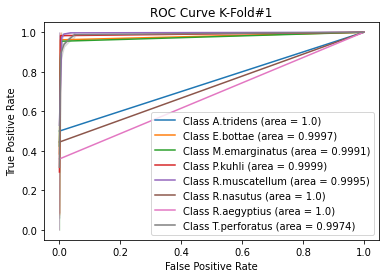

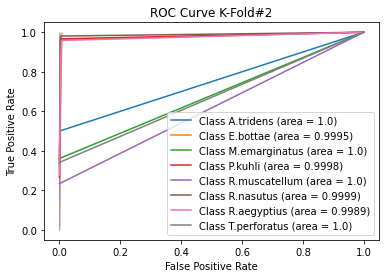

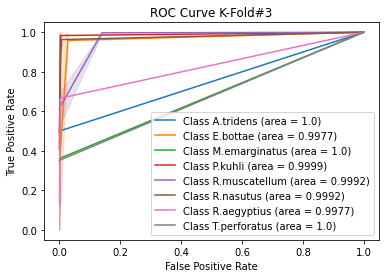

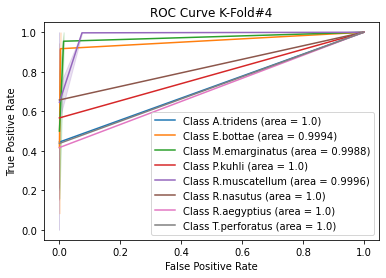

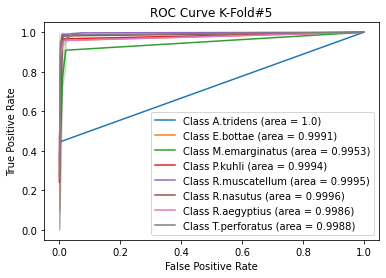

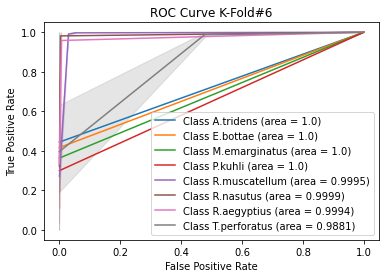

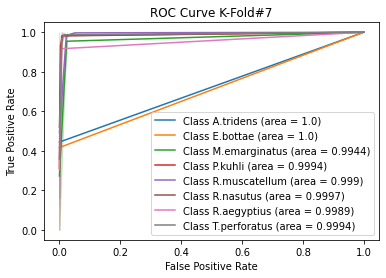

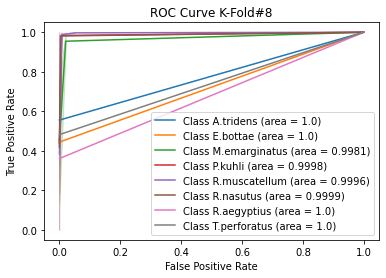

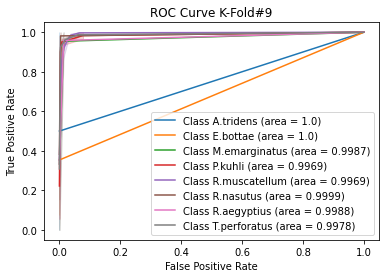

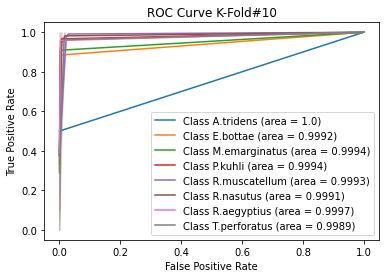

In [44]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [45]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9994664576315782
Std  0.0006714001549987053
Sp:  M.emarginatus
AUC Mean  0.9983748613041182
Std  0.0018731719136854908
Sp:  P.kuhli
AUC Mean  0.9994345417334374
Std  0.0008682538783694011
Sp:  R.muscatellum
AUC Mean  0.9992039766832193
Std  0.0008007596971807458
Sp:  R.nasutus
AUC Mean  0.9997028431504787
Std  0.0003122566416065875
Sp:  R.aegyptius
AUC Mean  0.9991949051425845
Std  0.0007248043301513223
Sp:  T.perforatus
AUC Mean  0.998029047367336
Std  0.003439562860592505


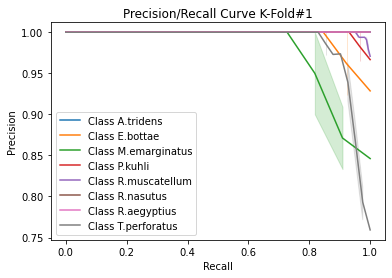

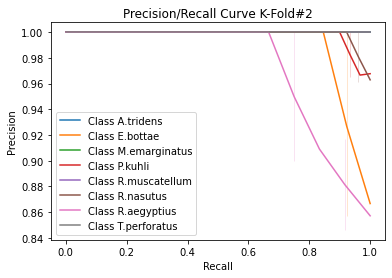

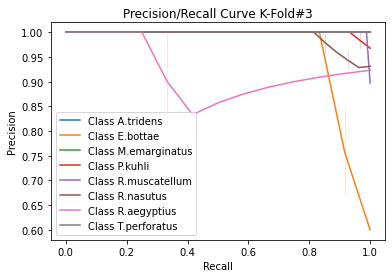

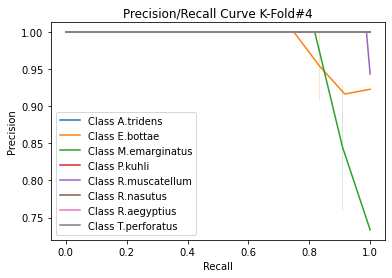

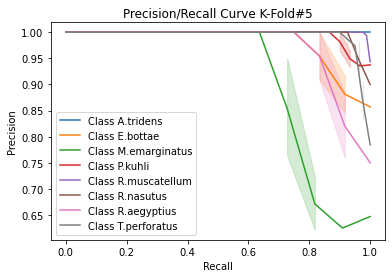

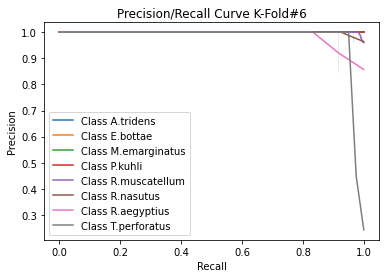

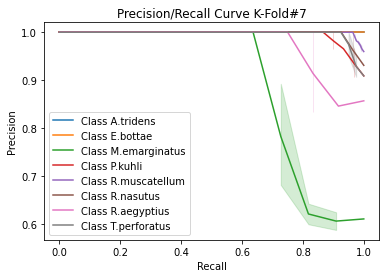

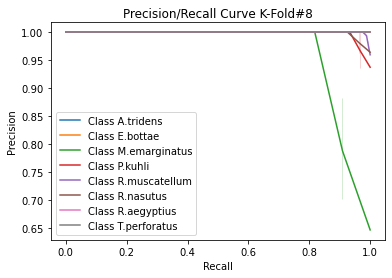

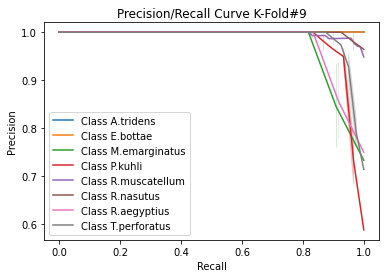

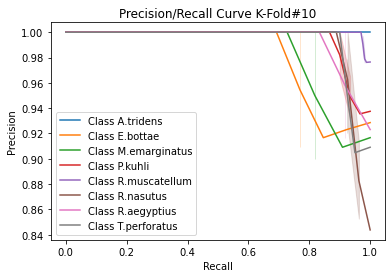

In [46]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1   9   1   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 165   0   0   1]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   1   0   0   2   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   1  29   0   0   0   0]
 [  0   0   0   0 166   0   0   0]
 [  0   0   0   0   0  25   1   0]
 [  0   0   0   1   0   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   0   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   1   0   0  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

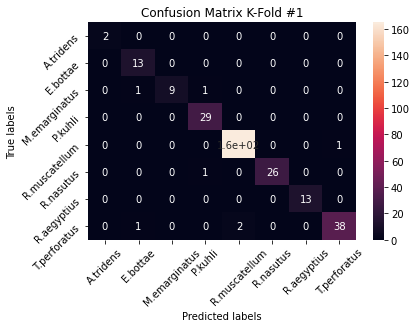

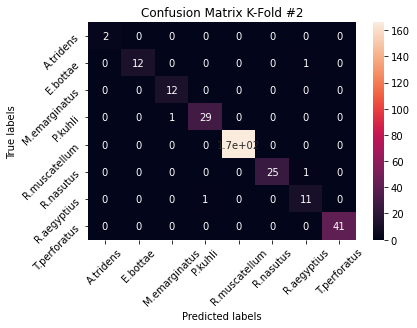

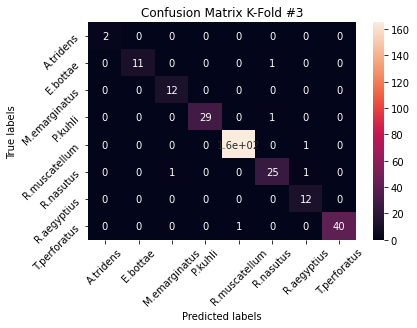

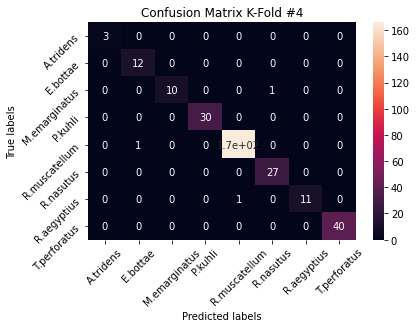

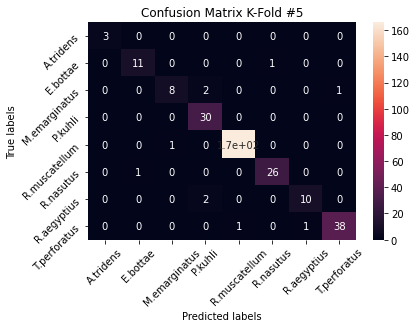

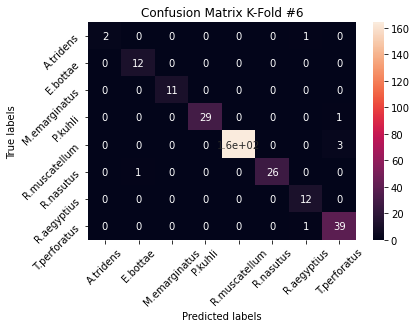

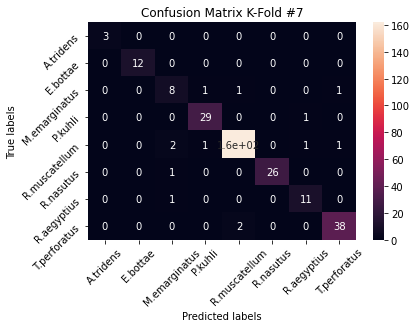

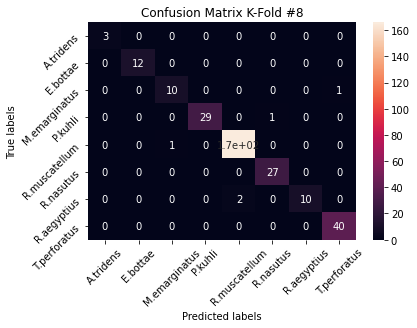

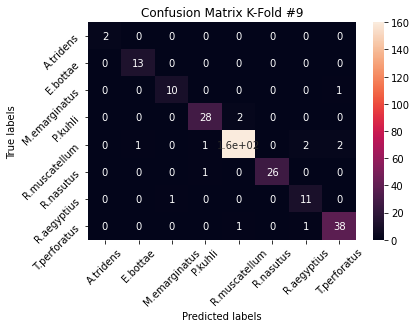

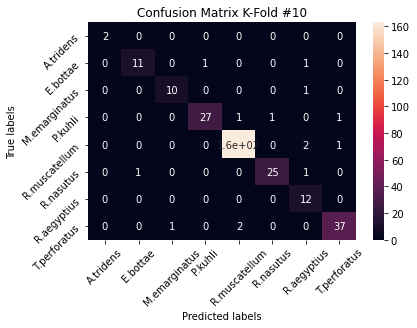

In [47]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  119    0    1    0    2    2    0]
 [   0    1  100    4    1    1    1    4]
 [   0    0    1  289    3    3    1    2]
 [   0    2    4    2 1643    0    6    8]
 [   0    3    2    2    0  259    3    0]
 [   0    0    2    3    3    0  113    0]
 [   0    1    1    0    9    0    3  389]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  38]]


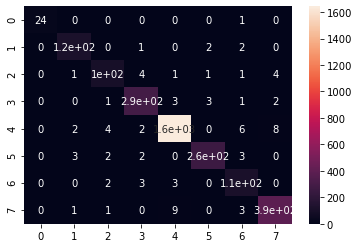

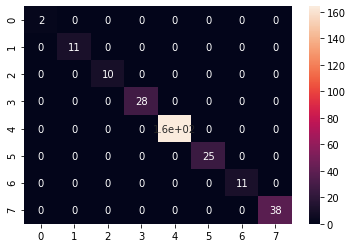

In [48]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.96 0.   0.01 0.   0.02 0.02 0.  ]
 [0.   0.01 0.89 0.04 0.01 0.01 0.01 0.04]
 [0.   0.   0.   0.97 0.01 0.01 0.   0.01]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.96 0.01 0.  ]
 [0.   0.   0.02 0.02 0.02 0.   0.93 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.01 0.97]]


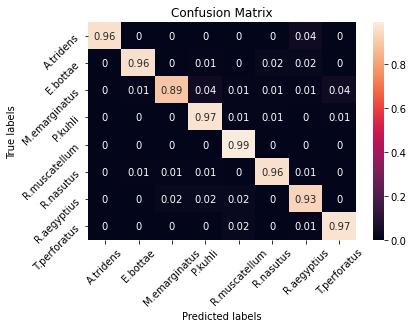

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V4 !!!!! K-Fold Training and Evaluation</h2>

In [50]:
folder = "models"
mode_version = "mel_smote_v4"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v4


In [51]:

def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(256)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(64)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [52]:
model = build_current_model()
model.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_209 (Bat (None, 56, 85, 56)        224       
_________________________________________________________________
activation_209 (Activation)  (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_209 (Dropout)        (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 14, 22, 72)        100

In [53]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 5s - loss: 1.7213 - accuracy: 0.3466 - val_loss: 1.6015 - val_accuracy: 0.3566
Epoch 2/100
1199/1199 - 6s - loss: 1.3527 - accuracy: 0.4827 - val_loss: 0.8913 - val_accuracy: 0.6783
Epoch 3/100
1199/1199 - 5s - loss: 1.0151 - accuracy: 0.6407 - val_loss: 0.7606 - val_accuracy: 0.7096
Epoch 4/100
1199/1199 - 5s - loss: 0.6995 - accuracy: 0.7719 - val_loss: 0.5854 - val_accuracy: 0.8143
Epoch 5/100
1199/1199 - 6s - loss: 0.5620 - accuracy: 0.8220 - val_loss: 0.4063 - val_accuracy: 0.8474

Epoch 77/100
1199/1199 - 5s - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.0678 - val_accuracy: 0.9853
Epoch 78/100
1199/1199 - 6s - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.0905 - val_accuracy: 0.9835
Epoch 79/100
Restoring model weights from the end of the best epoch.
1199/1199 - 6s - loss: 0.0319 - accuracy: 0.9909 - val_loss: 0.1039 - val_accuracy: 0.9779
Epoch 00079: early stopping
models/mel_smote_v4_iter_2.model
INFO:tensorflow:Assets written to: models/mel_smote_v4_iter_2.model/assets
Original trainingset shape [('T.perforatus', 289), ('R.muscatellum', 1199), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 215), ('M.emarginatus', 80), ('R.nasutus', 194), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('E.bottae', 1199), ('R.aegyptius', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.nasutus', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/10

Epoch 14/100
1198/1198 - 6s - loss: 0.1737 - accuracy: 0.9482 - val_loss: 0.1528 - val_accuracy: 0.9522
Epoch 15/100
1198/1198 - 6s - loss: 0.1630 - accuracy: 0.9485 - val_loss: 0.1511 - val_accuracy: 0.9467
Epoch 16/100
1198/1198 - 6s - loss: 0.1500 - accuracy: 0.9567 - val_loss: 0.2313 - val_accuracy: 0.9357
Epoch 17/100
1198/1198 - 6s - loss: 0.1585 - accuracy: 0.9540 - val_loss: 0.1304 - val_accuracy: 0.9540
Epoch 18/100
1198/1198 - 6s - loss: 0.1436 - accuracy: 0.9578 - val_loss: 0.1389 - val_accuracy: 0.9522
Epoch 19/100
1198/1198 - 5s - loss: 0.1304 - accuracy: 0.9618 - val_loss: 0.1433 - val_accuracy: 0.9614
Epoch 20/100
1198/1198 - 6s - loss: 0.1215 - accuracy: 0.9632 - val_loss: 0.1020 - val_accuracy: 0.9632
Epoch 21/100
1198/1198 - 5s - loss: 0.1262 - accuracy: 0.9631 - val_loss: 0.1100 - val_accuracy: 0.9614
Epoch 22/100
1198/1198 - 6s - loss: 0.1248 - accuracy: 0.9653 - val_loss: 0.1121 - val_accuracy: 0.9632
Epoch 23/100
1198/1198 - 6s - loss: 0.1174 - accuracy: 0.9683 - 

Epoch 10/100
1198/1198 - 6s - loss: 0.2488 - accuracy: 0.9239 - val_loss: 0.2229 - val_accuracy: 0.9375
Epoch 11/100
1198/1198 - 6s - loss: 0.2192 - accuracy: 0.9329 - val_loss: 0.1503 - val_accuracy: 0.9540
Epoch 12/100
1198/1198 - 6s - loss: 0.1924 - accuracy: 0.9422 - val_loss: 0.1381 - val_accuracy: 0.9632
Epoch 13/100
1198/1198 - 6s - loss: 0.1939 - accuracy: 0.9445 - val_loss: 0.3083 - val_accuracy: 0.9246
Epoch 14/100
1198/1198 - 5s - loss: 0.1584 - accuracy: 0.9535 - val_loss: 0.1436 - val_accuracy: 0.9614
Epoch 15/100
1198/1198 - 6s - loss: 0.1489 - accuracy: 0.9562 - val_loss: 0.1306 - val_accuracy: 0.9651
Epoch 16/100
1198/1198 - 5s - loss: 0.1462 - accuracy: 0.9587 - val_loss: 0.6005 - val_accuracy: 0.8382
Epoch 17/100
1198/1198 - 5s - loss: 0.1445 - accuracy: 0.9592 - val_loss: 0.1382 - val_accuracy: 0.9559
Epoch 18/100
1198/1198 - 6s - loss: 0.1411 - accuracy: 0.9583 - val_loss: 0.1955 - val_accuracy: 0.9540
Epoch 19/100
1198/1198 - 6s - loss: 0.1171 - accuracy: 0.9671 - 

Epoch 2/100
1198/1198 - 5s - loss: 1.2428 - accuracy: 0.5374 - val_loss: 1.1260 - val_accuracy: 0.6765
Epoch 3/100
1198/1198 - 6s - loss: 0.9446 - accuracy: 0.6603 - val_loss: 0.5629 - val_accuracy: 0.8125
Epoch 4/100
1198/1198 - 5s - loss: 0.6559 - accuracy: 0.7783 - val_loss: 0.6237 - val_accuracy: 0.8070
Epoch 5/100
1198/1198 - 6s - loss: 0.5080 - accuracy: 0.8372 - val_loss: 0.2774 - val_accuracy: 0.9136
Epoch 6/100
1198/1198 - 6s - loss: 0.4021 - accuracy: 0.8754 - val_loss: 0.3294 - val_accuracy: 0.8860
Epoch 7/100
1198/1198 - 6s - loss: 0.3326 - accuracy: 0.8942 - val_loss: 0.2263 - val_accuracy: 0.9283
Epoch 8/100
1198/1198 - 6s - loss: 0.3033 - accuracy: 0.9057 - val_loss: 0.2052 - val_accuracy: 0.9301
Epoch 9/100
1198/1198 - 6s - loss: 0.2501 - accuracy: 0.9221 - val_loss: 0.2201 - val_accuracy: 0.9301
Epoch 10/100
1198/1198 - 6s - loss: 0.2274 - accuracy: 0.9326 - val_loss: 0.2091 - val_accuracy: 0.9375
Epoch 11/100
1198/1198 - 6s - loss: 0.2086 - accuracy: 0.9392 - val_loss

Epoch 35/100
1198/1198 - 6s - loss: 0.0820 - accuracy: 0.9781 - val_loss: 0.1105 - val_accuracy: 0.9761
Epoch 36/100
1198/1198 - 6s - loss: 0.0787 - accuracy: 0.9784 - val_loss: 0.1262 - val_accuracy: 0.9779
Epoch 37/100
1198/1198 - 6s - loss: 0.0757 - accuracy: 0.9782 - val_loss: 0.1391 - val_accuracy: 0.9743
Epoch 38/100
1198/1198 - 6s - loss: 0.0849 - accuracy: 0.9763 - val_loss: 0.1144 - val_accuracy: 0.9743
Epoch 39/100
1198/1198 - 6s - loss: 0.0635 - accuracy: 0.9831 - val_loss: 0.0918 - val_accuracy: 0.9798
Epoch 40/100
1198/1198 - 6s - loss: 0.0734 - accuracy: 0.9793 - val_loss: 0.0955 - val_accuracy: 0.9798
Epoch 41/100
1198/1198 - 6s - loss: 0.0657 - accuracy: 0.9791 - val_loss: 0.0930 - val_accuracy: 0.9908
Epoch 42/100
1198/1198 - 6s - loss: 0.0773 - accuracy: 0.9786 - val_loss: 0.0932 - val_accuracy: 0.9798
Epoch 43/100
Restoring model weights from the end of the best epoch.
1198/1198 - 6s - loss: 0.0655 - accuracy: 0.9814 - val_loss: 0.0810 - val_accuracy: 0.9853
Epoch 00

Epoch 00063: early stopping
models/mel_smote_v4_iter_8.model
INFO:tensorflow:Assets written to: models/mel_smote_v4_iter_8.model/assets
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1199), ('P.kuhli', 215), ('M.emarginatus', 81), ('R.aegyptius', 87), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.aegyptius', 1199), ('R.nasutus', 1199), ('E.bottae', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 5s - loss: 1.7632 - accuracy: 0.3235 - val_loss: 1.3843 - val_accuracy: 0.4596
Epoch 2/100
1199/1199 - 6s - loss: 1.3733 - accuracy: 0.4787 - val_loss: 0.7923 - val_accuracy: 0.7077
Epoch 3/100
1199/1199 - 5s - loss: 0.9520 - accuracy: 0.6534 - val_loss: 0.5677 - val_accuracy: 0.8107
Epoch 4/100
1199/1199 - 5s - loss: 0.6981 - accuracy: 0.7546 - val_lo

Epoch 74/100
1199/1199 - 6s - loss: 0.0459 - accuracy: 0.9881 - val_loss: 0.0884 - val_accuracy: 0.9706
Epoch 75/100
1199/1199 - 6s - loss: 0.0402 - accuracy: 0.9863 - val_loss: 0.1463 - val_accuracy: 0.9688
Epoch 76/100
1199/1199 - 6s - loss: 0.0514 - accuracy: 0.9861 - val_loss: 0.1308 - val_accuracy: 0.9688
Epoch 77/100
Restoring model weights from the end of the best epoch.
1199/1199 - 6s - loss: 0.0457 - accuracy: 0.9876 - val_loss: 0.0956 - val_accuracy: 0.9669
Epoch 00077: early stopping
models/mel_smote_v4_iter_9.model
INFO:tensorflow:Assets written to: models/mel_smote_v4_iter_9.model/assets
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1199), ('P.kuhli', 215), ('M.emarginatus', 81), ('R.aegyptius', 87), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.aegyptius', 1199), ('R.nasutus', 1199), ('E.bottae', 1199), ('A.triden

## Load and eval

In [54]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8

In [55]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
        
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

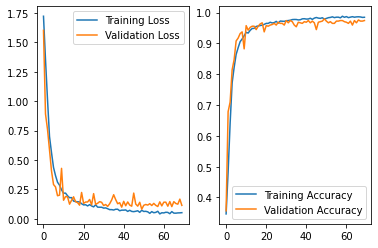

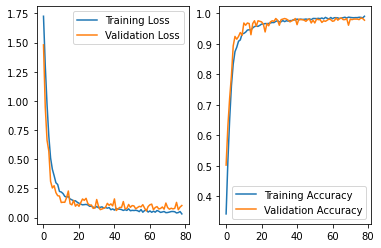

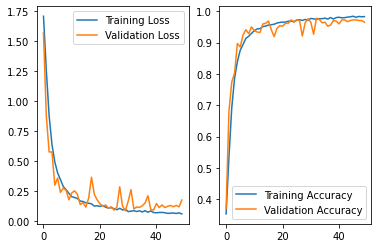

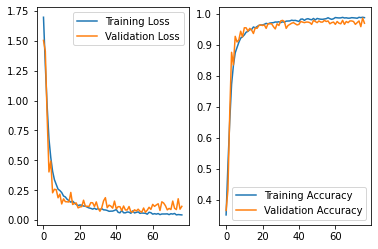

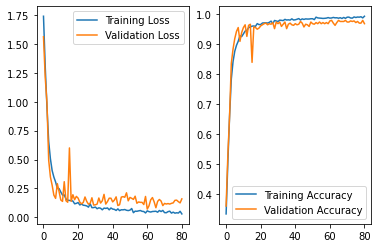

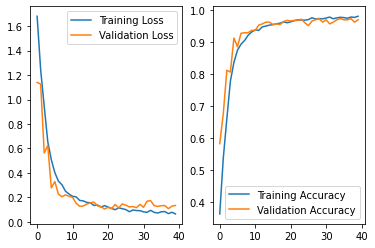

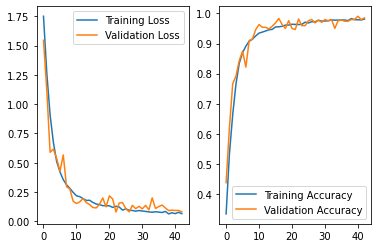

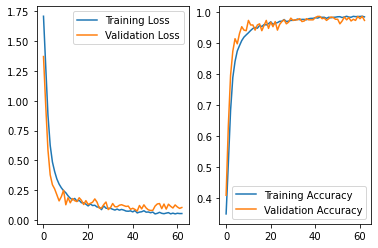

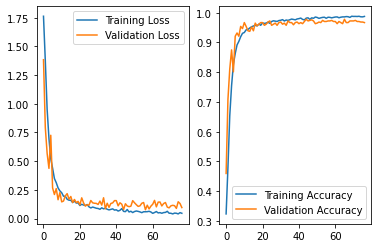

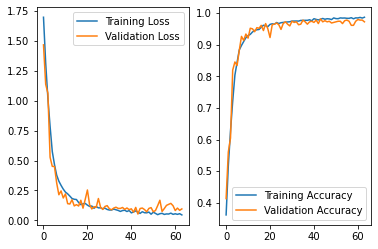

In [56]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [57]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.96294872 0.92825175 0.9779789  0.99039691 0.97558201
 0.91868132 0.95703234]
precision sdev by class [0.         0.04777925 0.07635851 0.03621231 0.00763081 0.04109617
 0.06835306 0.03595326]
macro precision mean 0.9638589925604105
macro precision sdev 0.019061750308643356
recall mean [0.93333333 0.95961538 0.88257576 0.97321839 0.98738908 0.96666667
 0.96666667 0.9752439 ]
recall sdev [0.2        0.0648704  0.08210178 0.03268514 0.0068298  0.02592593
 0.04082483 0.02705586]
macro recall mean 0.9555886474210731
macro recall sdev 0.0282822975545136
f1 mean [0.95       0.95941841 0.90238378 0.97493018 0.98887058 0.97054891
 0.94052372 0.96575001]
f1 sdev [0.15       0.04048235 0.06362198 0.02446799 0.00571856 0.02576025
 0.04308594 0.02710059]
macro f1 mean 0.9565531976359827
macro f1 sdev 0.025310586716230953
accuracy mean 0.9761369386812172
accuracy sdev 0.012651744187288464


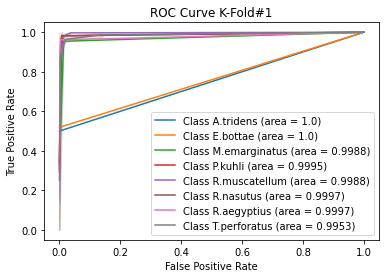

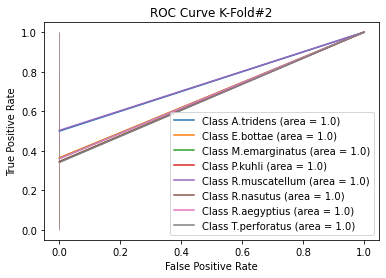

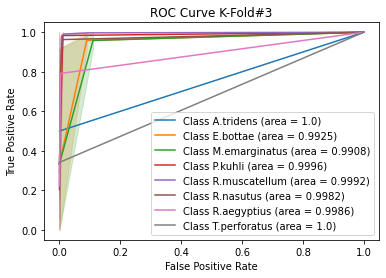

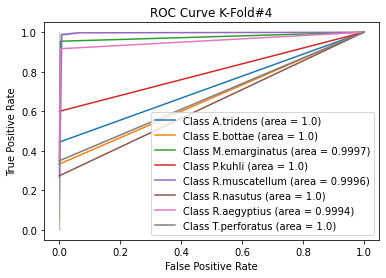

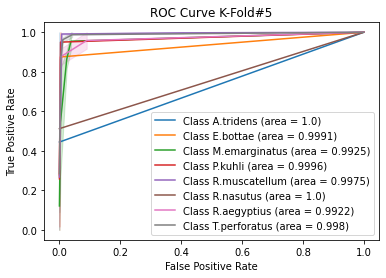

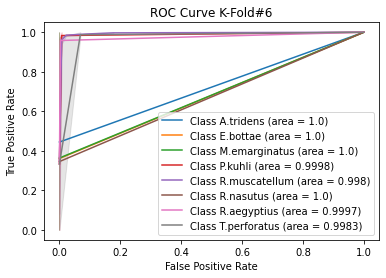

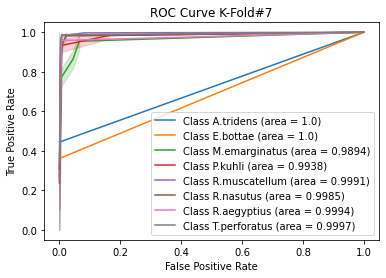

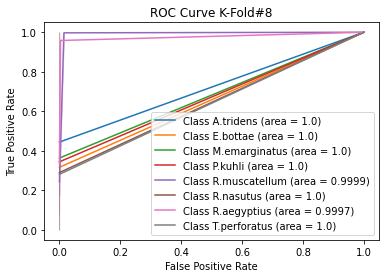

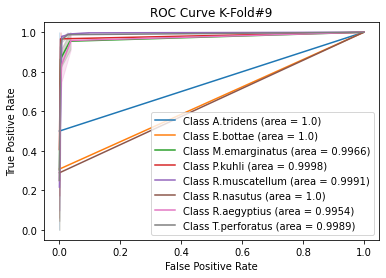

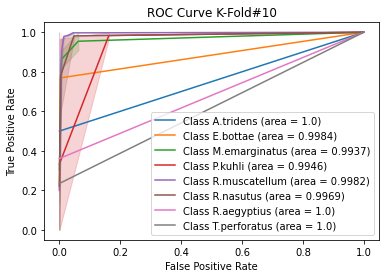

In [58]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [59]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9990064102564103
Std  0.002219435966011772
Sp:  M.emarginatus
AUC Mean  0.9961405379784335
Std  0.003968544185225923
Sp:  P.kuhli
AUC Mean  0.998660630937802
Std  0.002259644292731228
Sp:  R.muscatellum
AUC Mean  0.9989429655139677
Std  0.0007815834525661501
Sp:  R.nasutus
AUC Mean  0.9993389368133894
Std  0.0010309366487278736
Sp:  R.aegyptius
AUC Mean  0.9984200679803831
Std  0.0024388658445299487
Sp:  T.perforatus
AUC Mean  0.9990266266047761
Std  0.0014322959098365257


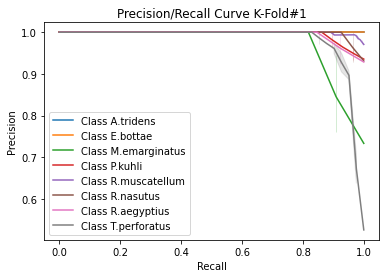

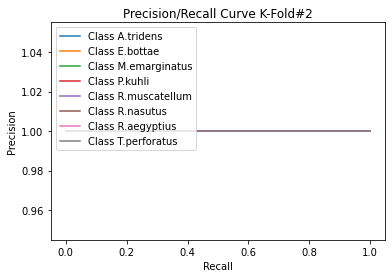

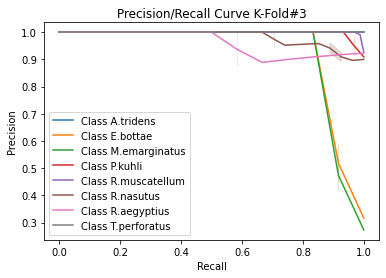

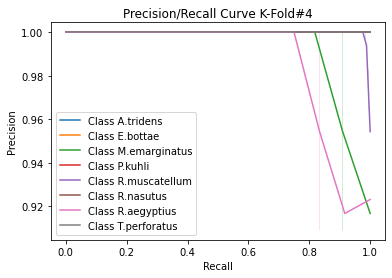

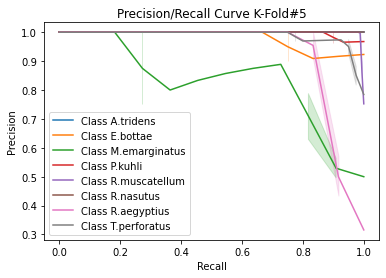

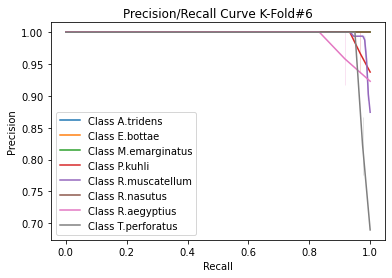

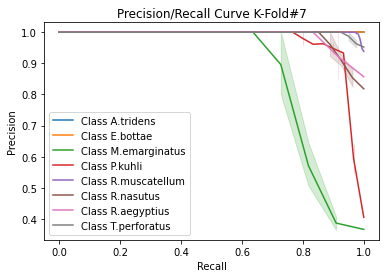

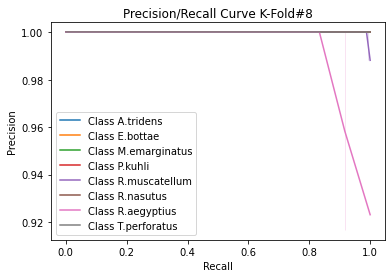

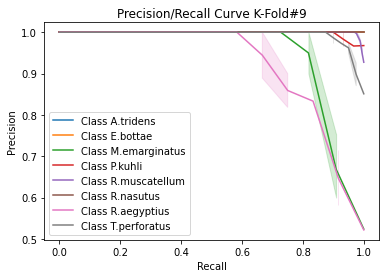

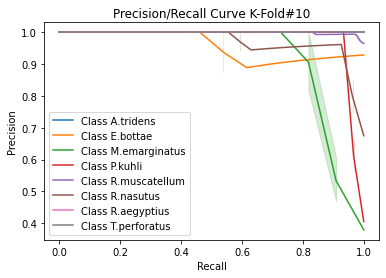

In [60]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1   9   0   0   0   0   1]
 [  0   0   0  28   1   0   0   0]
 [  0   0   0   0 163   0   0   3]
 [  0   0   0   1   0  25   1   0]
 [  0   0   0   0   0   0  13   0]
 [  0   1   0   0   2   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   0   0   0 166   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   1   1   0   0]
 [  0   0  11   0   1   0   0   0]
 [  0   0   0  28   0   2   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   0  27   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

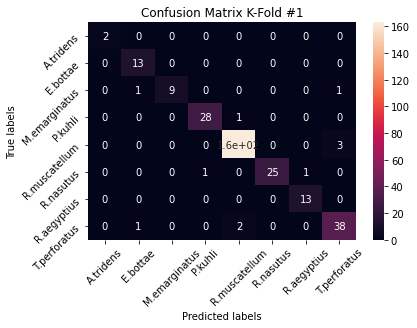

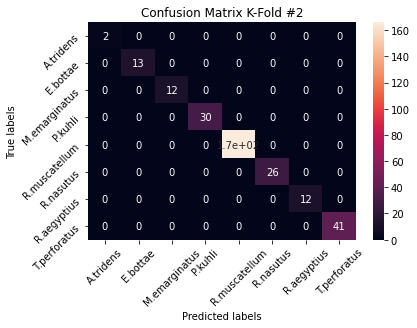

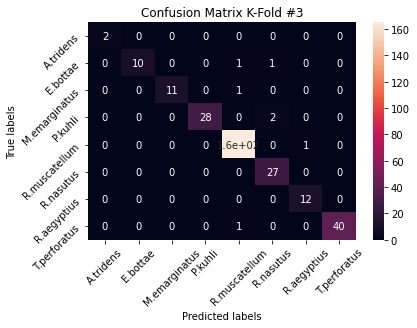

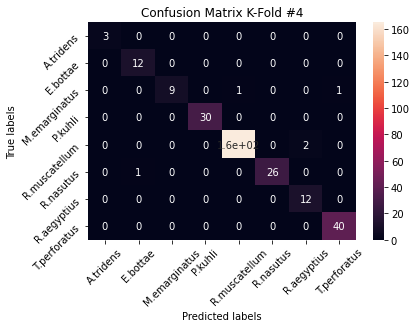

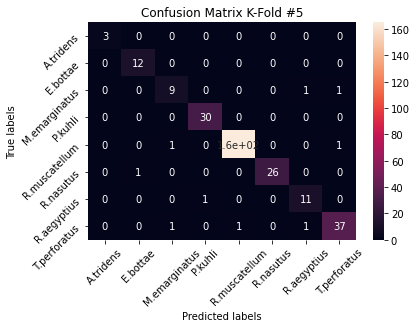

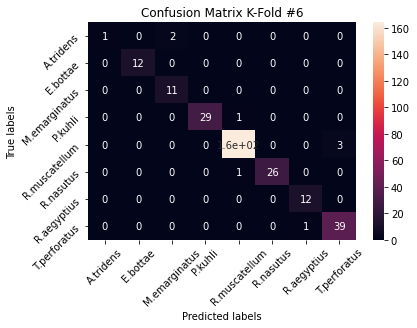

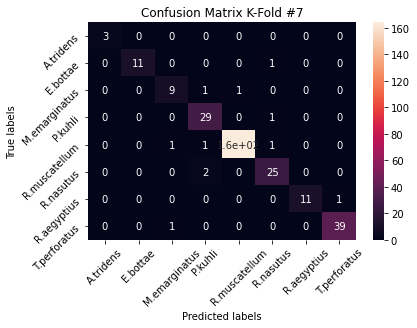

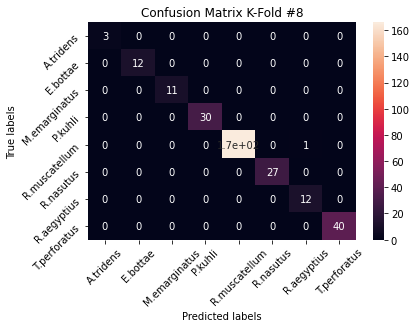

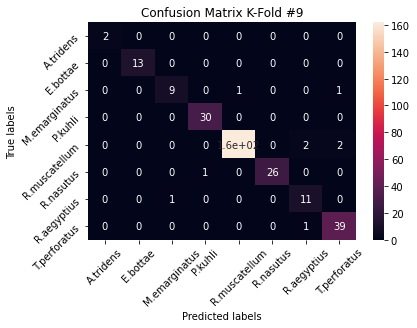

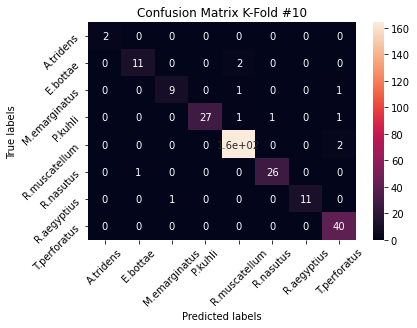

In [61]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    2    0    0    0    0    0]
 [   0  119    0    0    3    2    0    0]
 [   0    1   99    1    5    0    1    5]
 [   0    0    0  291    3    4    0    1]
 [   0    0    2    1 1644    1    6   11]
 [   0    3    0    4    1  260    1    0]
 [   0    0    2    1    0    0  117    1]
 [   0    1    2    0    4    0    3  393]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 164   0   0   1]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


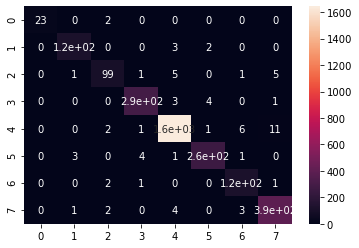

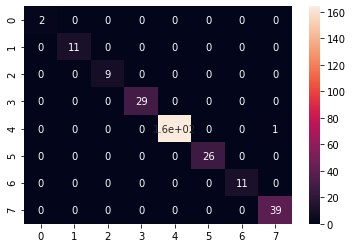

In [62]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.08 0.   0.   0.   0.   0.  ]
 [0.   0.96 0.   0.   0.02 0.02 0.   0.  ]
 [0.   0.01 0.88 0.01 0.04 0.   0.01 0.04]
 [0.   0.   0.   0.97 0.01 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.01]
 [0.   0.01 0.   0.01 0.   0.97 0.   0.  ]
 [0.   0.   0.02 0.01 0.   0.   0.97 0.01]
 [0.   0.   0.   0.   0.01 0.   0.01 0.98]]


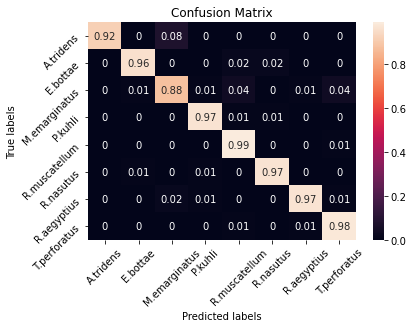

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V5 !!!!! K-Fold Training and Evaluation</h2>

In [64]:
folder = "models"
mode_version = "mel_smote_v5"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v5


In [65]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [66]:
model = build_current_model()
model.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_286 (Bat (None, 56, 85, 56)        224       
_________________________________________________________________
activation_286 (Activation)  (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 14, 22, 72)        100

In [67]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 5s - loss: 1.6411 - accuracy: 0.3770 - val_loss: 1.6755 - val_accuracy: 0.3143
Epoch 2/100
1199/1199 - 6s - loss: 1.1987 - accuracy: 0.5496 - val_loss: 0.8154 - val_accuracy: 0.6875
Epoch 3/100
1199/1199 - 5s - loss: 0.8239 - accuracy: 0.7016 - val_loss: 0.5956 - val_accuracy: 0.7665
Epoch 4/100
1199/1199 - 6s - loss: 0.5965 - accuracy: 0.7977 - val_loss: 0.5859 - val_accuracy: 0.7923
Epoch 5/100
1199/1199 - 5s - loss: 0.4258 - accuracy: 0.8573 - val_loss: 0.3286 - val_accuracy: 0.8971

Epoch 33/100
1199/1199 - 5s - loss: 0.0561 - accuracy: 0.9835 - val_loss: 0.1352 - val_accuracy: 0.9743
Epoch 34/100
1199/1199 - 5s - loss: 0.0475 - accuracy: 0.9869 - val_loss: 0.1392 - val_accuracy: 0.9688
Epoch 35/100
1199/1199 - 6s - loss: 0.0441 - accuracy: 0.9877 - val_loss: 0.1008 - val_accuracy: 0.9779
Epoch 36/100
1199/1199 - 6s - loss: 0.0512 - accuracy: 0.9850 - val_loss: 0.1298 - val_accuracy: 0.9743
Epoch 37/100
1199/1199 - 6s - loss: 0.0500 - accuracy: 0.9853 - val_loss: 0.1075 - val_accuracy: 0.9779
Epoch 38/100
1199/1199 - 5s - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.1137 - val_accuracy: 0.9743
Epoch 39/100
1199/1199 - 6s - loss: 0.0415 - accuracy: 0.9869 - val_loss: 0.1802 - val_accuracy: 0.9651
Epoch 40/100
1199/1199 - 5s - loss: 0.0452 - accuracy: 0.9873 - val_loss: 0.0955 - val_accuracy: 0.9743
Epoch 41/100
1199/1199 - 5s - loss: 0.0462 - accuracy: 0.9862 - val_loss: 0.0987 - val_accuracy: 0.9779
Epoch 42/100
1199/1199 - 6s - loss: 0.0525 - accuracy: 0.9856 - 

Epoch 3/100
1198/1198 - 5s - loss: 0.8938 - accuracy: 0.6711 - val_loss: 0.8314 - val_accuracy: 0.7169
Epoch 4/100
1198/1198 - 5s - loss: 0.6199 - accuracy: 0.7868 - val_loss: 0.6434 - val_accuracy: 0.7849
Epoch 5/100
1198/1198 - 6s - loss: 0.4692 - accuracy: 0.8462 - val_loss: 0.4592 - val_accuracy: 0.8456
Epoch 6/100
1198/1198 - 5s - loss: 0.3471 - accuracy: 0.8892 - val_loss: 0.3637 - val_accuracy: 0.8989
Epoch 7/100
1198/1198 - 6s - loss: 0.2834 - accuracy: 0.9122 - val_loss: 0.2302 - val_accuracy: 0.9246
Epoch 8/100
1198/1198 - 6s - loss: 0.2476 - accuracy: 0.9247 - val_loss: 0.2574 - val_accuracy: 0.9265
Epoch 9/100
1198/1198 - 6s - loss: 0.2102 - accuracy: 0.9340 - val_loss: 0.2440 - val_accuracy: 0.9338
Epoch 10/100
1198/1198 - 5s - loss: 0.1848 - accuracy: 0.9427 - val_loss: 0.2136 - val_accuracy: 0.9522
Epoch 11/100
1198/1198 - 6s - loss: 0.1559 - accuracy: 0.9508 - val_loss: 0.2448 - val_accuracy: 0.9320
Epoch 12/100
1198/1198 - 5s - loss: 0.1373 - accuracy: 0.9596 - val_los

Epoch 3/100
1198/1198 - 5s - loss: 0.8718 - accuracy: 0.6868 - val_loss: 0.6715 - val_accuracy: 0.7169
Epoch 4/100
1198/1198 - 5s - loss: 0.5604 - accuracy: 0.8118 - val_loss: 0.6631 - val_accuracy: 0.7794
Epoch 5/100
1198/1198 - 5s - loss: 0.3971 - accuracy: 0.8708 - val_loss: 0.3100 - val_accuracy: 0.9081
Epoch 6/100
1198/1198 - 5s - loss: 0.3070 - accuracy: 0.9029 - val_loss: 0.3116 - val_accuracy: 0.9118
Epoch 7/100
1198/1198 - 6s - loss: 0.2520 - accuracy: 0.9236 - val_loss: 0.4122 - val_accuracy: 0.8805
Epoch 8/100
1198/1198 - 6s - loss: 0.1998 - accuracy: 0.9399 - val_loss: 0.2030 - val_accuracy: 0.9485
Epoch 9/100
1198/1198 - 5s - loss: 0.1882 - accuracy: 0.9441 - val_loss: 0.2498 - val_accuracy: 0.9228
Epoch 10/100
1198/1198 - 5s - loss: 0.1716 - accuracy: 0.9500 - val_loss: 0.1804 - val_accuracy: 0.9412
Epoch 11/100
1198/1198 - 6s - loss: 0.1560 - accuracy: 0.9528 - val_loss: 0.1889 - val_accuracy: 0.9485
Epoch 12/100
1198/1198 - 6s - loss: 0.1401 - accuracy: 0.9581 - val_los

Epoch 11/100
1198/1198 - 5s - loss: 0.1623 - accuracy: 0.9556 - val_loss: 0.2051 - val_accuracy: 0.9191
Epoch 12/100
1198/1198 - 6s - loss: 0.1467 - accuracy: 0.9588 - val_loss: 0.1676 - val_accuracy: 0.9559
Epoch 13/100
1198/1198 - 6s - loss: 0.1362 - accuracy: 0.9589 - val_loss: 0.1577 - val_accuracy: 0.9596
Epoch 14/100
1198/1198 - 5s - loss: 0.1243 - accuracy: 0.9667 - val_loss: 0.2765 - val_accuracy: 0.9210
Epoch 15/100
1198/1198 - 6s - loss: 0.1195 - accuracy: 0.9659 - val_loss: 0.1583 - val_accuracy: 0.9522
Epoch 16/100
1198/1198 - 5s - loss: 0.1180 - accuracy: 0.9665 - val_loss: 0.1029 - val_accuracy: 0.9724
Epoch 17/100
1198/1198 - 6s - loss: 0.0896 - accuracy: 0.9734 - val_loss: 0.1037 - val_accuracy: 0.9724
Epoch 18/100
1198/1198 - 5s - loss: 0.1096 - accuracy: 0.9685 - val_loss: 0.1160 - val_accuracy: 0.9632
Epoch 19/100
1198/1198 - 5s - loss: 0.0958 - accuracy: 0.9754 - val_loss: 0.1036 - val_accuracy: 0.9724
Epoch 20/100
1198/1198 - 5s - loss: 0.0866 - accuracy: 0.9740 - 

Epoch 16/100
1198/1198 - 6s - loss: 0.1030 - accuracy: 0.9688 - val_loss: 0.1731 - val_accuracy: 0.9614
Epoch 17/100
1198/1198 - 5s - loss: 0.0994 - accuracy: 0.9701 - val_loss: 0.1421 - val_accuracy: 0.9596
Epoch 18/100
1198/1198 - 5s - loss: 0.0844 - accuracy: 0.9752 - val_loss: 0.1600 - val_accuracy: 0.9596
Epoch 19/100
1198/1198 - 6s - loss: 0.0869 - accuracy: 0.9727 - val_loss: 0.1774 - val_accuracy: 0.9577
Epoch 20/100
1198/1198 - 6s - loss: 0.0860 - accuracy: 0.9735 - val_loss: 0.1912 - val_accuracy: 0.9485
Epoch 21/100
1198/1198 - 6s - loss: 0.0746 - accuracy: 0.9784 - val_loss: 0.1709 - val_accuracy: 0.9522
Epoch 22/100
1198/1198 - 6s - loss: 0.0714 - accuracy: 0.9819 - val_loss: 0.1563 - val_accuracy: 0.9651
Epoch 23/100
1198/1198 - 5s - loss: 0.0772 - accuracy: 0.9755 - val_loss: 0.1316 - val_accuracy: 0.9669
Epoch 24/100
1198/1198 - 5s - loss: 0.0714 - accuracy: 0.9787 - val_loss: 0.1413 - val_accuracy: 0.9651
Epoch 25/100
1198/1198 - 6s - loss: 0.0665 - accuracy: 0.9789 - 

Epoch 28/100
1199/1199 - 5s - loss: 0.0668 - accuracy: 0.9821 - val_loss: 0.1164 - val_accuracy: 0.9614
Epoch 29/100
1199/1199 - 6s - loss: 0.0659 - accuracy: 0.9805 - val_loss: 0.1123 - val_accuracy: 0.9688
Epoch 30/100
1199/1199 - 5s - loss: 0.0541 - accuracy: 0.9853 - val_loss: 0.1363 - val_accuracy: 0.9651
Epoch 31/100
1199/1199 - 6s - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.1707 - val_accuracy: 0.9559
Epoch 32/100
1199/1199 - 6s - loss: 0.0592 - accuracy: 0.9836 - val_loss: 0.1229 - val_accuracy: 0.9632
Epoch 33/100
1199/1199 - 6s - loss: 0.0552 - accuracy: 0.9834 - val_loss: 0.1393 - val_accuracy: 0.9669
Epoch 34/100
1199/1199 - 6s - loss: 0.0461 - accuracy: 0.9860 - val_loss: 0.1414 - val_accuracy: 0.9651
Epoch 35/100
1199/1199 - 6s - loss: 0.0404 - accuracy: 0.9881 - val_loss: 0.1273 - val_accuracy: 0.9651
Epoch 36/100
1199/1199 - 6s - loss: 0.0496 - accuracy: 0.9852 - val_loss: 0.1127 - val_accuracy: 0.9669
Epoch 37/100
1199/1199 - 6s - loss: 0.0408 - accuracy: 0.9867 - 

Epoch 33/100
1199/1199 - 6s - loss: 0.0630 - accuracy: 0.9829 - val_loss: 0.1152 - val_accuracy: 0.9669
Epoch 34/100
1199/1199 - 6s - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.1645 - val_accuracy: 0.9577
Epoch 35/100
1199/1199 - 6s - loss: 0.0553 - accuracy: 0.9847 - val_loss: 0.1677 - val_accuracy: 0.9614
Epoch 36/100
1199/1199 - 5s - loss: 0.0476 - accuracy: 0.9864 - val_loss: 0.1461 - val_accuracy: 0.9669
Epoch 37/100
1199/1199 - 5s - loss: 0.0428 - accuracy: 0.9888 - val_loss: 0.1424 - val_accuracy: 0.9669
Epoch 38/100
1199/1199 - 7s - loss: 0.0572 - accuracy: 0.9848 - val_loss: 0.1406 - val_accuracy: 0.9651
Epoch 39/100
1199/1199 - 5s - loss: 0.0427 - accuracy: 0.9870 - val_loss: 0.1597 - val_accuracy: 0.9724
Epoch 40/100
1199/1199 - 6s - loss: 0.0471 - accuracy: 0.9864 - val_loss: 0.1017 - val_accuracy: 0.9743
Epoch 41/100
1199/1199 - 6s - loss: 0.0521 - accuracy: 0.9845 - val_loss: 0.0949 - val_accuracy: 0.9706
Epoch 42/100
1199/1199 - 6s - loss: 0.0338 - accuracy: 0.9911 - 

# LOAD AND EVAL

In [68]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [69]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
       
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

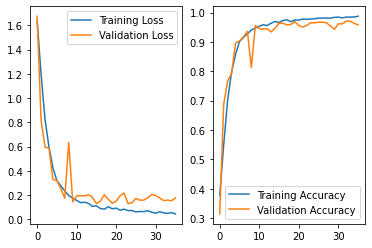

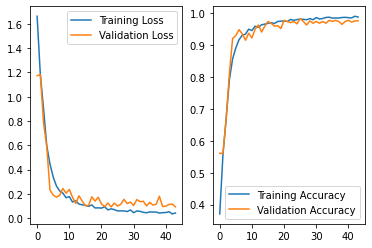

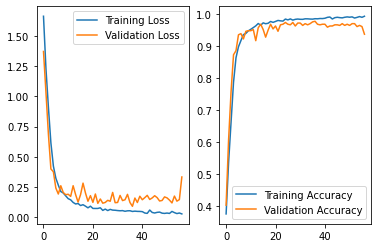

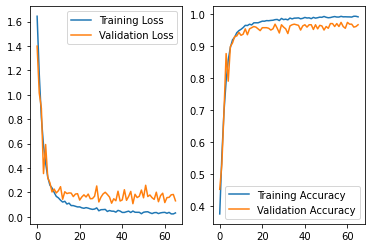

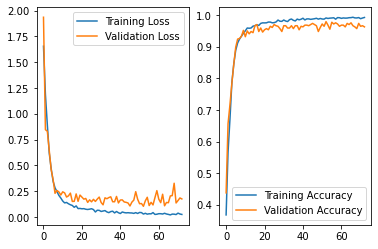

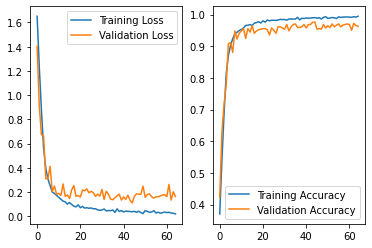

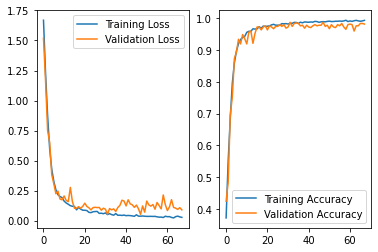

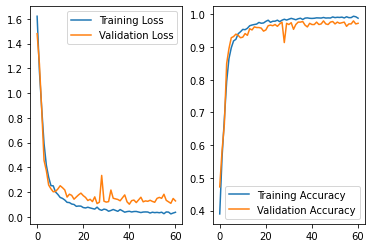

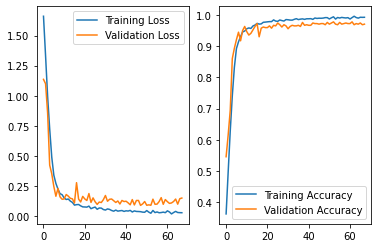

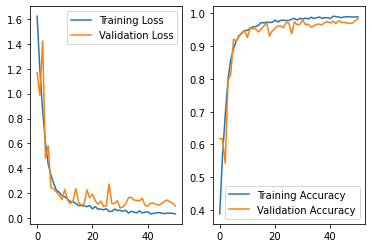

In [70]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [71]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.94747253 0.91343143 0.97269441 0.9811291  0.97775743
 0.88454212 0.95608396]
precision sdev by class [0.         0.04583849 0.09538355 0.0199246  0.01620707 0.02459522
 0.07516383 0.02507355]
macro precision mean 0.9541388715786796
macro precision sdev 0.014080888603589702
recall mean [0.93333333 0.96858974 0.88257576 0.94632184 0.98139745 0.95883191
 0.95064103 0.96268293]
recall sdev [0.2        0.05163739 0.10816367 0.0375637  0.01296952 0.03945869
 0.04034389 0.03209171]
macro recall mean 0.9480467476191512
macro recall sdev 0.025671784158928967
f1 mean [0.95       0.95682011 0.89052882 0.95894539 0.98109823 0.96773944
 0.91426756 0.95901657]
f1 sdev [0.15       0.03738074 0.06944901 0.0237067  0.00743443 0.02570817
 0.0435711  0.02241885]
macro f1 mean 0.9473020155816542
macro f1 sdev 0.01697848839729319
accuracy mean 0.9675210666431979
accuracy sdev 0.009605834618593895


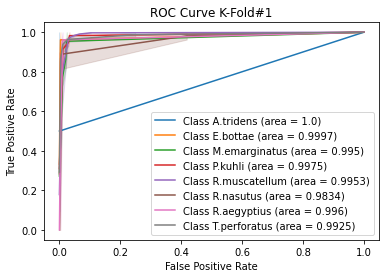

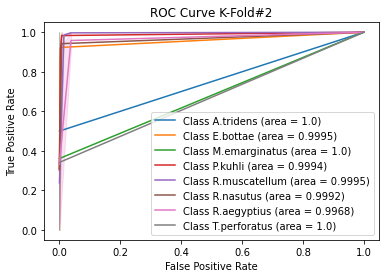

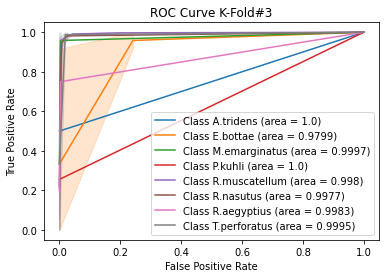

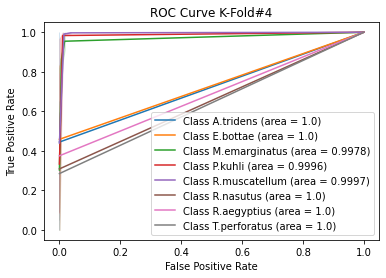

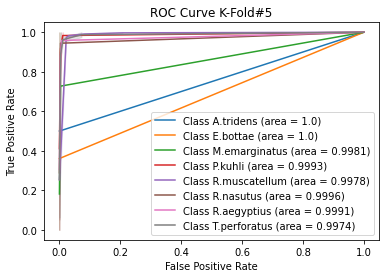

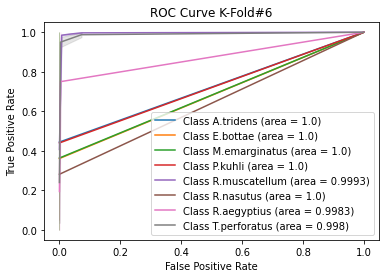

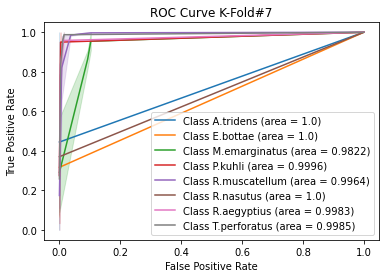

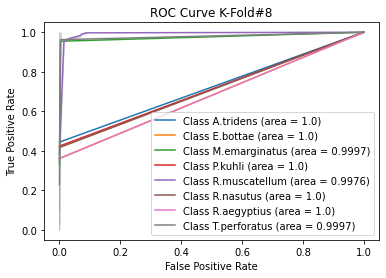

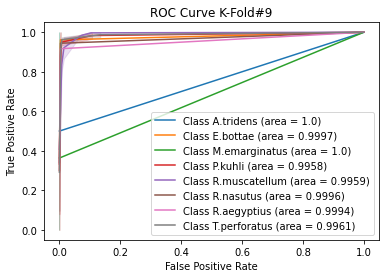

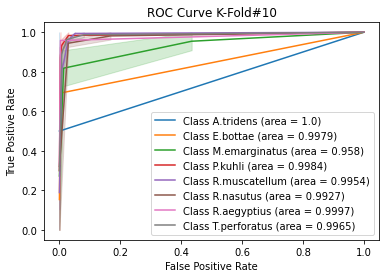

In [72]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [73]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9976682701868391
Std  0.005960138878264848
Sp:  M.emarginatus
AUC Mean  0.9930527367525233
Std  0.012776654928558515
Sp:  P.kuhli
AUC Mean  0.9989609399433327
Std  0.001296844041235793
Sp:  R.muscatellum
AUC Mean  0.9974763499617035
Std  0.001600671627998445
Sp:  R.nasutus
AUC Mean  0.9972199835262353
Std  0.005066401967626348
Sp:  R.aegyptius
AUC Mean  0.9985946998552894
Std  0.0012751474046547371
Sp:  T.perforatus
AUC Mean  0.9978192422981087
Std  0.0022271013121671376


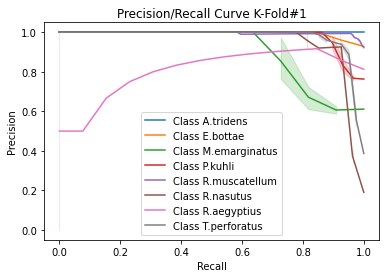

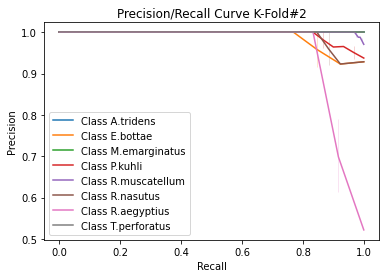

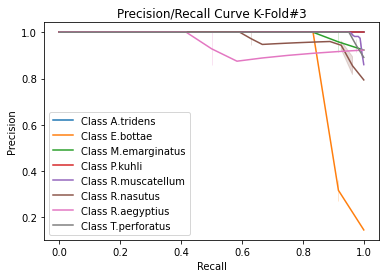

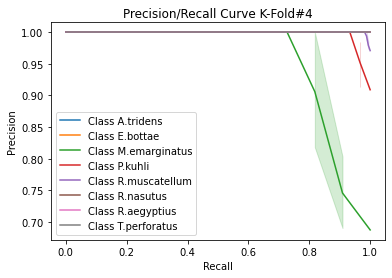

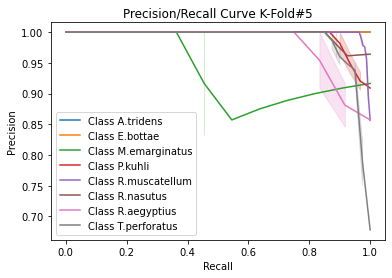

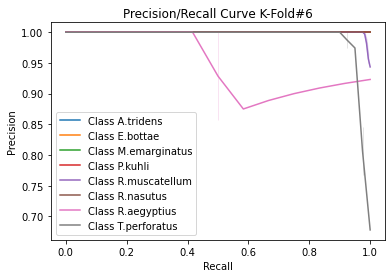

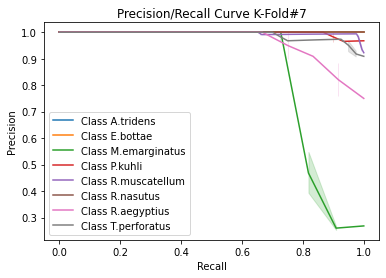

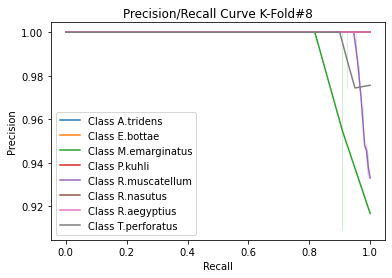

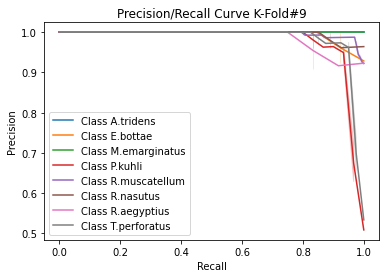

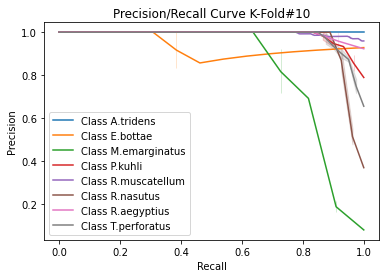

In [74]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   1   0   0   0]
 [  0   0   8   0   2   0   1   0]
 [  0   0   0  26   2   1   0   0]
 [  0   0   0   0 163   0   0   3]
 [  0   0   0   1   0  25   1   0]
 [  0   0   0   0   0   1  12   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   2   0   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   1   1  28   0   0   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   1   1  23   1   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   1   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   1   0   0 163   0   1   1]
 [  0   0   0   1   1  25   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

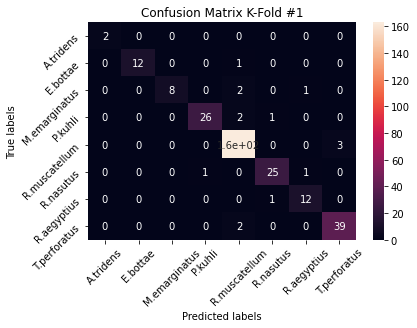

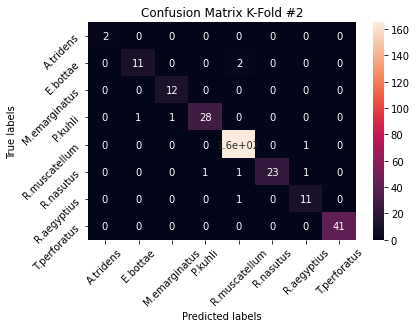

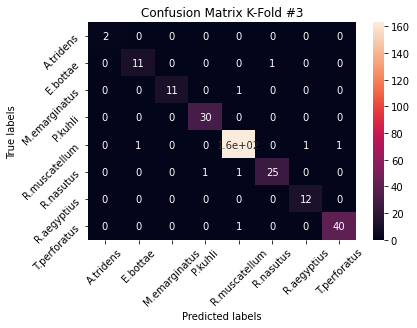

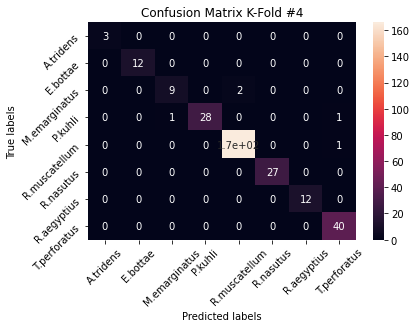

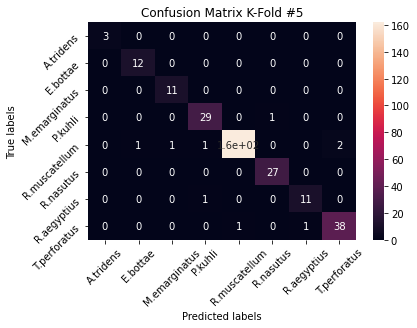

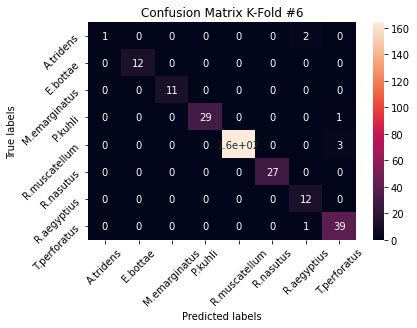

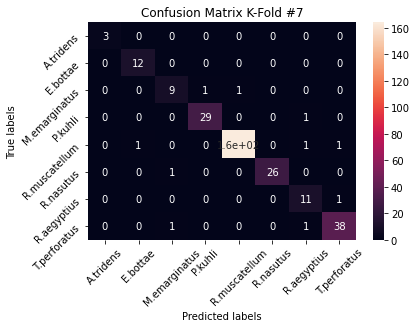

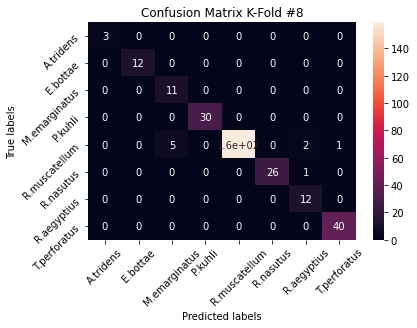

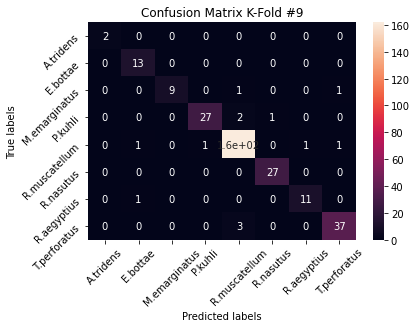

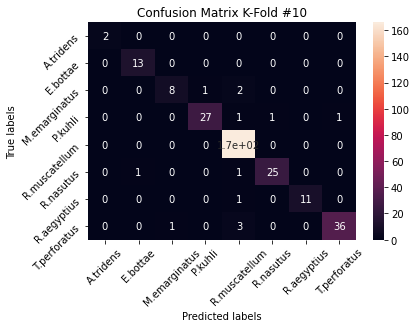

In [75]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  120    0    0    3    1    0    0]
 [   0    0   99    2    9    0    1    1]
 [   0    1    2  283    5    4    1    3]
 [   0    4    6    2 1634    0    6   13]
 [   0    1    1    3    3  258    3    0]
 [   0    1    0    1    2    1  115    1]
 [   0    0    2    0   10    0    3  388]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 163   0   0   1]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


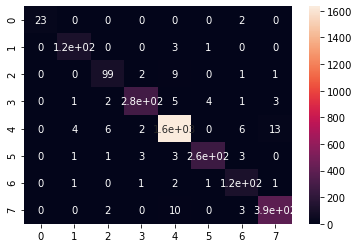

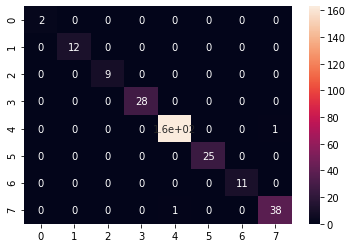

In [76]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.97 0.   0.   0.02 0.01 0.   0.  ]
 [0.   0.   0.88 0.02 0.08 0.   0.01 0.01]
 [0.   0.   0.01 0.95 0.02 0.01 0.   0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.   0.   0.01 0.01 0.96 0.01 0.  ]
 [0.   0.01 0.   0.01 0.02 0.01 0.95 0.01]
 [0.   0.   0.   0.   0.02 0.   0.01 0.96]]


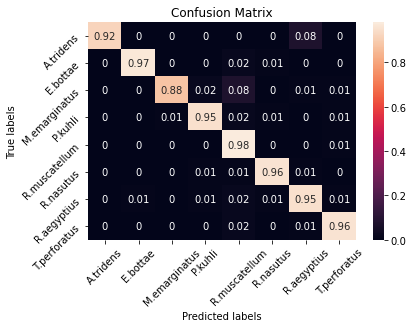

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

# V6 Re-Load Data

In [78]:
folder = "models"
mode_version = "mel_smote_v6"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/mel_smote_v6


In [79]:
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((85, 56))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [80]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 56, 85, 3)
(3018,)


In [81]:
def build_current_model():
    inp = Input(shape=(56,85,3))
    lay = Convolution2D(filters=48,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [82]:
model = build_current_model()
model.summary()

Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 56, 85, 3)]       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 28, 43, 48)        7104      
_________________________________________________________________
batch_normalization_363 (Bat (None, 28, 43, 48)        192       
_________________________________________________________________
activation_363 (Activation)  (None, 28, 43, 48)        0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 14, 22, 48)        0         
_________________________________________________________________
spatial_dropout2d_44 (Spatia (None, 14, 22, 48)        0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 7, 11, 32)         384

In [83]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 56, 85, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 6s - loss: 1.4189 - accuracy: 0.4634 - val_loss: 1.2918 - val_accuracy: 0.5018
Epoch 2/100
1199/1199 - 6s - loss: 0.7720 - accuracy: 0.7204 - val_loss: 0.5646 - val_accuracy: 0.7739
Epoch 3/100
1199/1199 - 6s - loss: 0.4432 - accuracy: 0.8422 - val_loss: 0.3477 - val_accuracy: 0.8787
Epoch 4/100
1199/1199 - 6s - loss: 0.3172 - accuracy: 0.8919 - val_loss: 0.2263 - val_accuracy: 0.9191
Epoch 5/100
1199/1199 - 6s - loss: 0.2619 - accuracy: 0.9131 - val_loss: 0.2831 - val_accuracy: 0.8989
E

Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('E.bottae', 1199), ('R.aegyptius', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.nasutus', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 56, 85, 3)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 6s - loss: 1.3321 - accuracy: 0.5046 - val_loss: 0.8055 - val_accuracy: 0.6765
Epoch 2/100
1199/1199 - 6s - loss: 0.6340 - accuracy: 0.7692 - val_loss: 0.6016 - val_accuracy: 0.8070
Epoch 3/100
1199/1199 - 5s - loss: 0.3843 - accuracy: 0.8730 - val_loss: 0.5538 - val_accuracy: 0.8419
Epoch 4/100
1199/1199 - 6s - loss: 0.2807 - accuracy: 0.9062 - val_loss: 0.2700 - val_accuracy: 0.9136
Epoch 5/100
1199/1199 - 5s - loss: 0.2269 - accuracy: 0.9242 - val_loss: 0.3357 - val_accuracy: 0.8897
Epoch 6/100
1199/1199 - 6s - loss: 0.2020 - accuracy: 0.9333 - val_loss: 0.2225 - val_accuracy: 0.9320
Epoch 7/100
1199/1199 - 5s - loss: 0.1726 - accuracy: 0.9482 - val_loss: 0.2625 - val_accurac

Epoch 26/100
1198/1198 - 7s - loss: 0.0598 - accuracy: 0.9827 - val_loss: 0.2228 - val_accuracy: 0.9485
Epoch 27/100
1198/1198 - 6s - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.2199 - val_accuracy: 0.9375
Epoch 28/100
1198/1198 - 6s - loss: 0.0441 - accuracy: 0.9876 - val_loss: 0.2218 - val_accuracy: 0.9467
Epoch 29/100
1198/1198 - 6s - loss: 0.0423 - accuracy: 0.9872 - val_loss: 0.2186 - val_accuracy: 0.9467
Epoch 30/100
1198/1198 - 6s - loss: 0.0386 - accuracy: 0.9881 - val_loss: 0.2077 - val_accuracy: 0.9522
Epoch 31/100
1198/1198 - 6s - loss: 0.0515 - accuracy: 0.9850 - val_loss: 0.2737 - val_accuracy: 0.9504
Epoch 32/100
1198/1198 - 6s - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.2433 - val_accuracy: 0.9485
Epoch 33/100
1198/1198 - 6s - loss: 0.0377 - accuracy: 0.9881 - val_loss: 0.1639 - val_accuracy: 0.9651
Epoch 34/100
1198/1198 - 6s - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.1596 - val_accuracy: 0.9559
Epoch 35/100
1198/1198 - 5s - loss: 0.0382 - accuracy: 0.9890 - 

Epoch 19/100
1198/1198 - 6s - loss: 0.0702 - accuracy: 0.9782 - val_loss: 0.1960 - val_accuracy: 0.9504
Epoch 20/100
1198/1198 - 6s - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.2231 - val_accuracy: 0.9596
Epoch 21/100
1198/1198 - 6s - loss: 0.0736 - accuracy: 0.9782 - val_loss: 0.2183 - val_accuracy: 0.9669
Epoch 22/100
1198/1198 - 6s - loss: 0.0516 - accuracy: 0.9846 - val_loss: 0.2546 - val_accuracy: 0.9504
Epoch 23/100
1198/1198 - 5s - loss: 0.0491 - accuracy: 0.9839 - val_loss: 0.2419 - val_accuracy: 0.9412
Epoch 24/100
1198/1198 - 6s - loss: 0.0561 - accuracy: 0.9808 - val_loss: 0.2269 - val_accuracy: 0.9596
Epoch 25/100
1198/1198 - 7s - loss: 0.0466 - accuracy: 0.9857 - val_loss: 0.2189 - val_accuracy: 0.9577
Epoch 26/100
1198/1198 - 6s - loss: 0.0499 - accuracy: 0.9851 - val_loss: 0.1766 - val_accuracy: 0.9651
Epoch 27/100
1198/1198 - 6s - loss: 0.0532 - accuracy: 0.9846 - val_loss: 0.2080 - val_accuracy: 0.9559
Epoch 28/100
1198/1198 - 6s - loss: 0.0473 - accuracy: 0.9848 - 

Epoch 35/100
1198/1198 - 7s - loss: 0.0385 - accuracy: 0.9888 - val_loss: 0.2091 - val_accuracy: 0.9430
Epoch 36/100
1198/1198 - 5s - loss: 0.0429 - accuracy: 0.9865 - val_loss: 0.1501 - val_accuracy: 0.9559
Epoch 37/100
1198/1198 - 5s - loss: 0.0403 - accuracy: 0.9890 - val_loss: 0.1461 - val_accuracy: 0.9577
Epoch 38/100
Restoring model weights from the end of the best epoch.
1198/1198 - 6s - loss: 0.0340 - accuracy: 0.9888 - val_loss: 0.1384 - val_accuracy: 0.9596
Epoch 00038: early stopping
models/mel_smote_v6_iter_8.model
INFO:tensorflow:Assets written to: models/mel_smote_v6_iter_8.model/assets
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1199), ('P.kuhli', 215), ('M.emarginatus', 81), ('R.aegyptius', 87), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.aegyptius', 1199), ('R.nasutus', 1199), ('E.bottae', 1199), ('A.triden

## LOAD AND EVAL

In [84]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [85]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
        
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

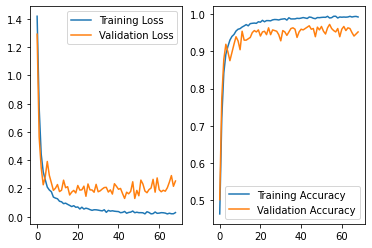

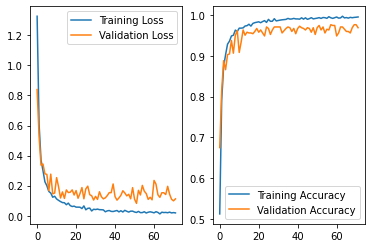

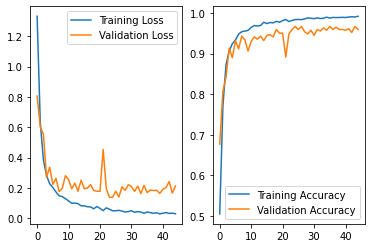

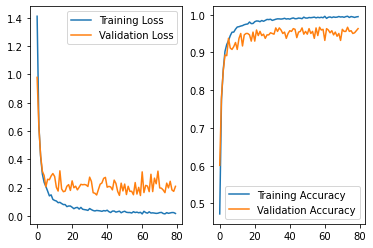

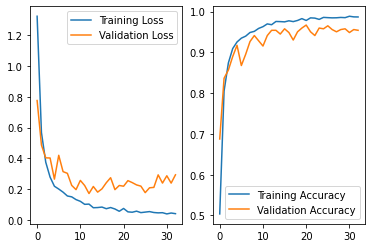

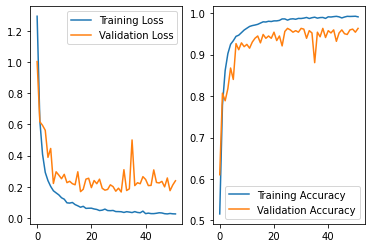

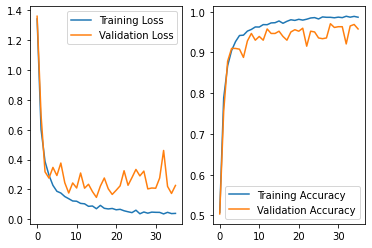

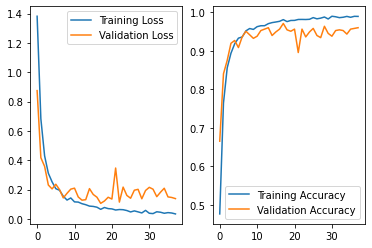

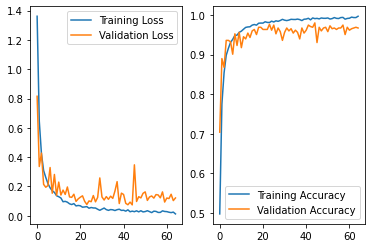

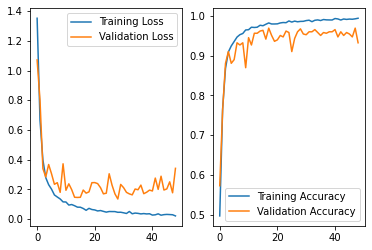

In [86]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [87]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.96849817 0.87938297 0.95877369 0.97861649 0.94883392
 0.81358274 0.95403211]
precision sdev by class [0.         0.03870973 0.12784195 0.02965359 0.01385605 0.03244072
 0.11112    0.03988084]
macro precision mean 0.937715010633988
macro precision sdev 0.012574640477281537
recall mean [0.93333333 0.95064103 0.82954545 0.92298851 0.98017459 0.95156695
 0.90961538 0.94530488]
recall sdev [0.2        0.05492284 0.0927373  0.04972643 0.00713679 0.03742944
 0.07747929 0.02681964]
macro recall mean 0.9278962655094922
macro recall sdev 0.03223357287911219
f1 mean [0.95       0.95849859 0.84370851 0.93992609 0.97933847 0.94978923
 0.85143166 0.94911843]
f1 sdev [0.15       0.03756187 0.07355581 0.03407807 0.00817035 0.02896724
 0.05575876 0.02609033]
macro f1 mean 0.927726374156553
macro f1 sdev 0.02134154889203717
accuracy mean 0.9572528657235265
accuracy sdev 0.009081263704844767


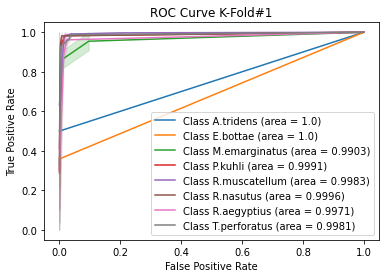

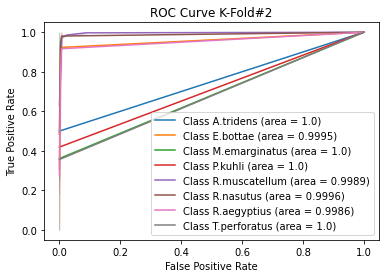

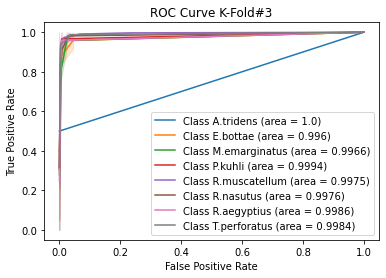

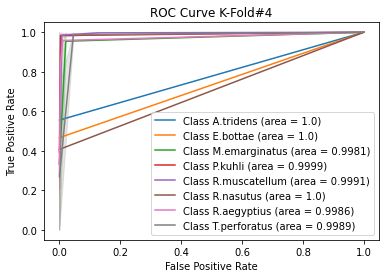

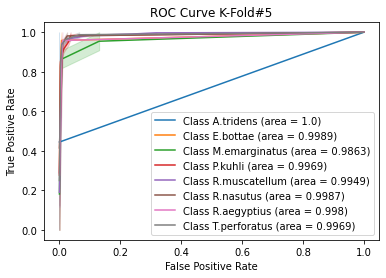

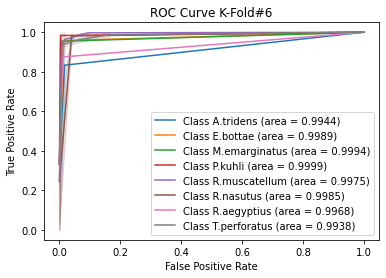

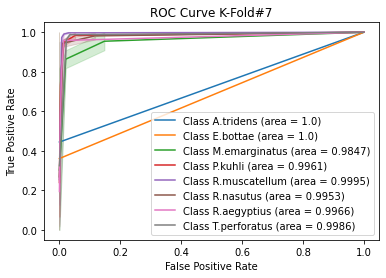

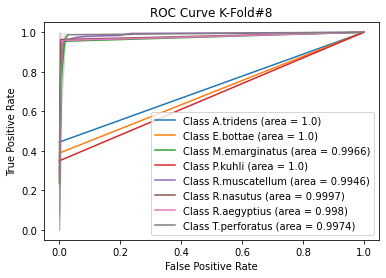

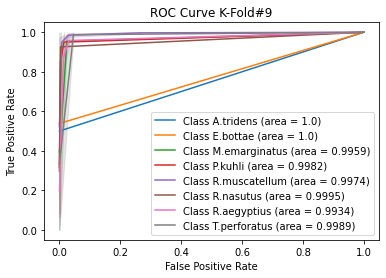

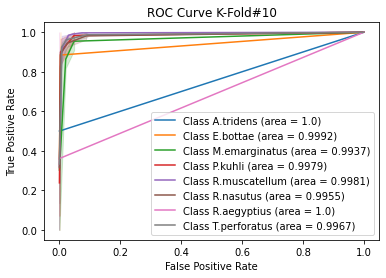

In [88]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [89]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.9994425863991081
Std  0.0016722408026755952
Sp:  E.bottae
AUC Mean  0.9992344539235573
Std  0.0011786273354401538
Sp:  M.emarginatus
AUC Mean  0.9941533357032822
Std  0.005086683963121254
Sp:  P.kuhli
AUC Mean  0.9987336650086739
Std  0.0013301424098715391
Sp:  R.muscatellum
AUC Mean  0.9975895097355488
Std  0.0015581722503434944
Sp:  R.nasutus
AUC Mean  0.9983940857442921
Std  0.0016406222643852446
Sp:  R.aegyptius
AUC Mean  0.9975497538694054
Std  0.001693720515083394
Sp:  T.perforatus
AUC Mean  0.9977727852002133
Std  0.0016164286746434475


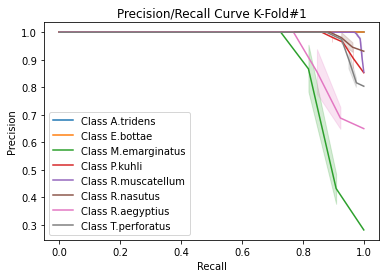

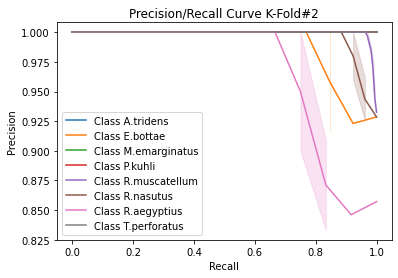

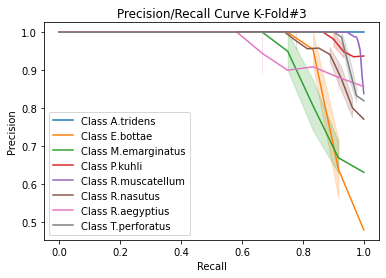

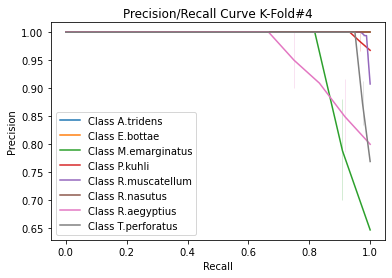

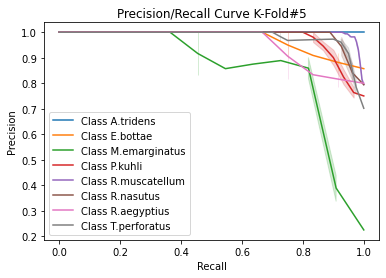

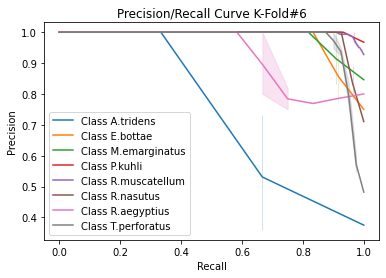

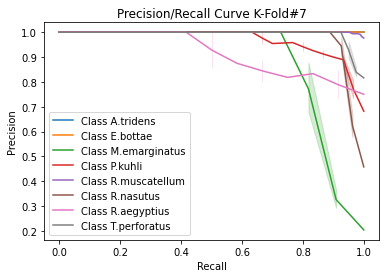

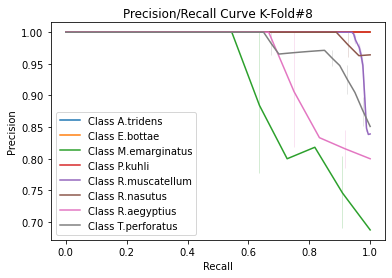

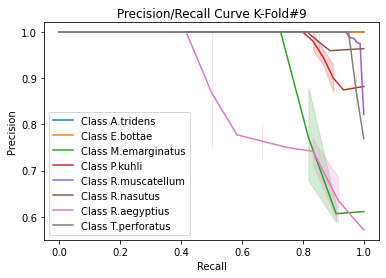

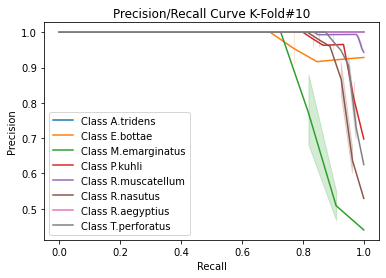

In [90]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  10   0   0   1   0   0]
 [  0   0   3  26   0   0   0   0]
 [  0   0   1   0 163   1   0   1]
 [  0   0   0   0   0  27   0   0]
 [  0   0   1   0   1   0  11   0]
 [  0   0   2   0   1   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   1   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   1   0   0 161   0   4   0]
 [  0   0   0   1   0  24   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0   9   0   1   0   1   1]
 [  0   0   0  28   0   1   0   1]
 [  0   0   0   0 163   0   1   2]
 [  0   0   1   1   1  24   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

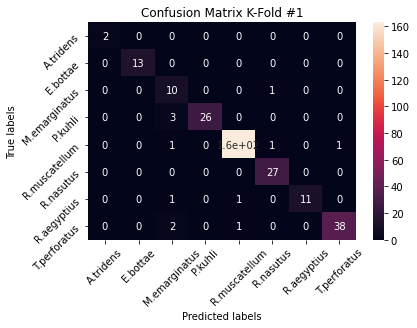

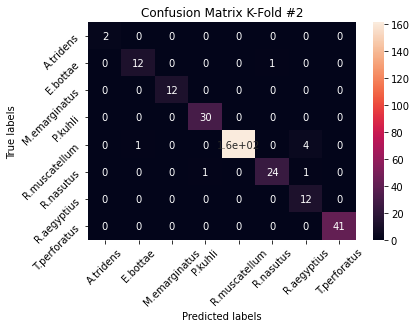

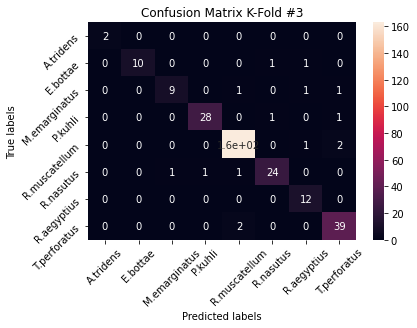

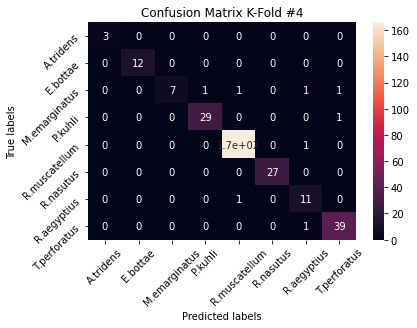

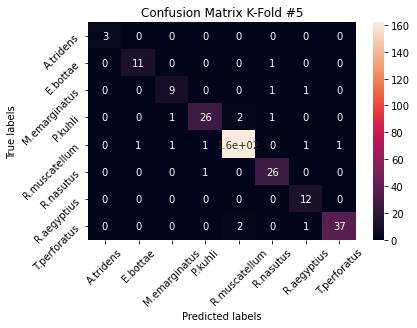

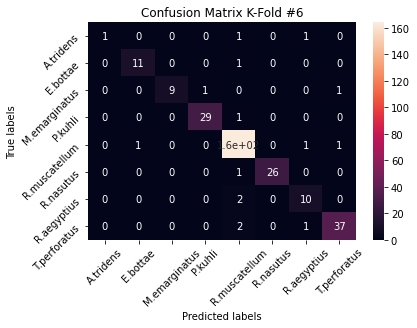

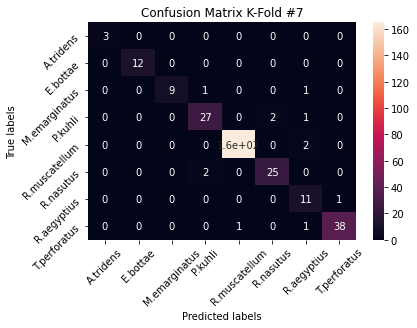

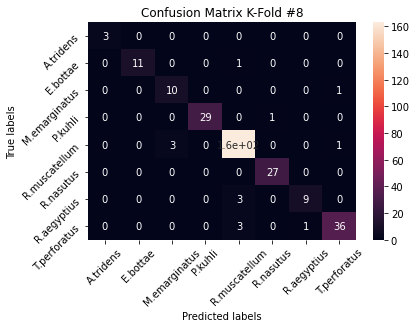

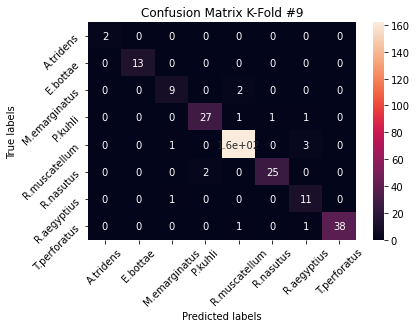

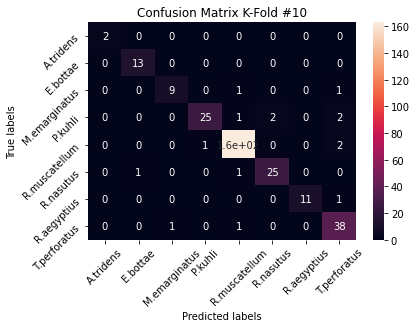

In [91]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    1    0    1    0]
 [   0  118    0    0    2    3    1    0]
 [   0    0   93    3    5    2    4    5]
 [   0    0    4  276    5    8    2    4]
 [   0    3    6    2 1632    1   13    8]
 [   0    1    1    7    3  256    1    0]
 [   0    0    2    0    7    0  110    2]
 [   0    0    3    0   13    0    6  381]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  27   0   0   0   0]
 [  0   0   0   0 163   0   1   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


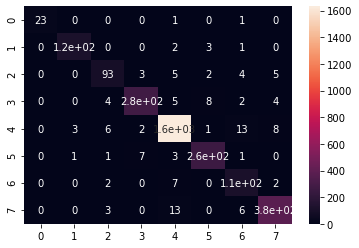

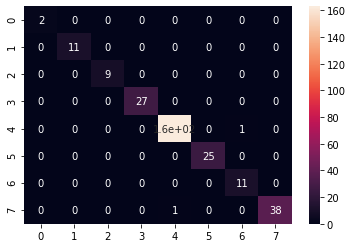

In [92]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.04 0.   0.04 0.  ]
 [0.   0.95 0.   0.   0.02 0.02 0.01 0.  ]
 [0.   0.   0.83 0.03 0.04 0.02 0.04 0.04]
 [0.   0.   0.01 0.92 0.02 0.03 0.01 0.01]
 [0.   0.   0.   0.   0.98 0.   0.01 0.  ]
 [0.   0.   0.   0.03 0.01 0.95 0.   0.  ]
 [0.   0.   0.02 0.   0.06 0.   0.91 0.02]
 [0.   0.   0.01 0.   0.03 0.   0.01 0.95]]


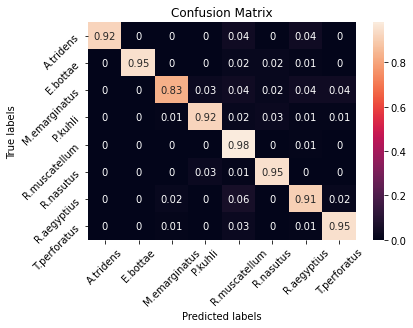

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);